# reanalysis

1)      Remove samples that are clearly dead (=very different samples)

2)      Remove proteins that are not found in both axenic cultures and co-cultures (-> keep for subsequent analyses)

3)      After removing, normalize?

   a.       Normalize each experimental group separately (eg. P, A and C)?

   b.       In the co-cultures, normalize each organism separately (sum of intensities across all proteins)?

4)      Look at ratios to one or more “housekeeping genes”

   a.       Select from RNAseq data a few genes that are expressed at an intermediate level and are stable. Add recA, rpoD, proC

   b.       Normalize each protein to these housekeeping proteins

   c.       Plot ratios

5)      Future – enrichment, correlation between RNA and protein, putting everything together into multi omics something




In [7]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')
#plt.rcParams["figure.dpi"] = 600
from sklearn.model_selection import train_test_split

In [8]:

HCOLOR = '#E26A2C'
HCOLOR_light = '#FDA65D'
PCOLOR = '#99cc99'
PCOLOR_light = '#aad5aa'

DONCOLOR = '#7285b7'
RDONCOLOR = 'black' #'#00334D'
DINCOLOR = '#bbdaff' #'#000066'

DOCCOLOR = '#cc6666'
RDOCCOLOR = 'black' #'#00334D'
DICCOLOR = '#ff9da4' #'#000066'

ccnpalette = [PCOLOR, HCOLOR, DONCOLOR, RDONCOLOR, DINCOLOR]
ccnorder = ['Bp', 'Bh', 'DON', 'RDON', 'DIN']
cccpalette = [PCOLOR, HCOLOR, DOCCOLOR, RDOCCOLOR, DICCOLOR]
cccorder = ['Bp[C]', 'Bh[C]', 'DOC', 'RDOC', 'DIC']
ccxpalette = [PCOLOR, HCOLOR]
ccxorder = ['Xp', 'Xh']
hnpalette = [ HCOLOR_light, DONCOLOR, RDONCOLOR, DINCOLOR]
hnorder = [ 'Bh', 'DON', 'RDON', 'DIN']
hcpalette = [ HCOLOR_light, DOCCOLOR, RDOCCOLOR, DICCOLOR]
hcorder = [ 'Bh[C]', 'DOC', 'RDOC', 'DIC']
pnpalette = [ PCOLOR_light, DONCOLOR, RDONCOLOR, DINCOLOR]
pnorder = [ 'Bp', 'DON', 'RDON', 'DIN']
pcpalette = [ PCOLOR_light, DOCCOLOR, RDOCCOLOR, DICCOLOR]
pcorder = [ 'Bp[C]', 'DOC', 'RDOC', 'DIC']
sns.color_palette(ccnpalette + cccpalette, )
# 


[(0.6, 0.8, 0.6),
 (0.8862745098039215, 0.41568627450980394, 0.17254901960784313),
 (0.4470588235294118, 0.5215686274509804, 0.7176470588235294),
 (0.0, 0.0, 0.0),
 (0.7333333333333333, 0.8549019607843137, 1.0),
 (0.6, 0.8, 0.6),
 (0.8862745098039215, 0.41568627450980394, 0.17254901960784313),
 (0.8, 0.4, 0.4),
 (0.0, 0.0, 0.0),
 (1.0, 0.615686274509804, 0.6431372549019608)]

In [9]:
mpalette = sns.color_palette('Accent', n_colors=8).as_hex()
#mpalette = [mpalette[0]] + mpalette[4:7]

AXENIC_COLOR = '#47B07B' # axenic (green ) 
COCULTURE = '#7D7D7D' # co-culture (grey) #7D7D7D
CC_COLOR = '#1B73D3'
#9479b9
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'
mpalette = [PRO_COLOR,ALT_COLOR, AXENIC_COLOR, COCULTURE, CC_COLOR ]
torder = ['med4', 'co-culture']
tpal = [PCOLOR_light, PRO_COLOR]
forder = ['med4 (AX)', 'med4 (CC)', '1A3 (CC)', '1A3 (AX)']
forder1 = forder + ['med4 (AX ALT)', '1A3 (AX PRO)']
fpal = [PCOLOR_light, PRO_COLOR, HCOLOR, HCOLOR_light,  ]
fpal1 = [PCOLOR_light, PRO_COLOR, HCOLOR, HCOLOR_light,  '#304529', '#6c361b',]
gorder = ['PRO', 'ALT']
gpal = [PRO_COLOR, HCOLOR]
sns.color_palette(gpal)

[(0.23529411764705882, 0.7019607843137254, 0.44313725490196076),
 (0.8862745098039215, 0.41568627450980394, 0.17254901960784313)]

In [10]:
sns.color_palette(fpal1)

[(0.6666666666666666, 0.8352941176470589, 0.6666666666666666),
 (0.23529411764705882, 0.7019607843137254, 0.44313725490196076),
 (0.8862745098039215, 0.41568627450980394, 0.17254901960784313),
 (0.9921568627450981, 0.6509803921568628, 0.36470588235294116),
 (0.18823529411764706, 0.27058823529411763, 0.1607843137254902),
 (0.4235294117647059, 0.21176470588235294, 0.10588235294117647)]

In [11]:
os.listdir('.')

['.ipynb_checkpoints',
 'CC1A3 proteome Nov22 normalization.ipynb',
 'CC1A3 proteome Nov22.ipynb',
 'data']

In [13]:
#pmm_df = pd.read_csv(os.path.join(RNA_dpath, 'MED4_PMM2locus.csv'), names=['gene_id', 'pmm'])
deseq_med4_df = pd.read_csv(os.path.join('..', 'RNASEQ', 'DE_results','MED4_DE_genes_DESEQ_wKEGG_ref_vs_long.csv'))
deseq_1a3_df = pd.read_csv(os.path.join('..', 'RNASEQ', 'DE_results','HOT1A3_DE_genes_DESEQ_ref_vs_long_wKEGG.csv'))
deseq_df = pd.concat([deseq_1a3_df, deseq_med4_df])

In [15]:
fpath =  os.path.join('data','Nov22_Processing.xlsx')

df1 = pd.read_excel(fpath, sheet_name=None)

In [16]:
df1.keys()

dict_keys(['MED4', 'HOT1A3', 'Combined'])

In [17]:
def _get_df(k):
    df = df1[k]
    df['sheet'] = k
    return df
dfs = [_get_df(k) for k in df1]
dfs

[                                      Protein Accession    Gene      Organism  \
 0     WP_011133152.1 photosystem I core protein PsaA...     NaN           NaN   
 1     WP_011132825.1 polyribonucleotide nucleotidylt...     NaN           NaN   
 2     WP_011132757.1 autotransporter outer membrane ...     NaN           NaN   
 3     WP_011132404.1 NADP-dependent phosphogluconate...     NaN           NaN   
 4     WP_011132401.1 class II fructose-bisphosphatas...     NaN           NaN   
 ...                                                 ...     ...           ...   
 1597  WP_011132451.1 high light inducible protein [P...     NaN           NaN   
 1598  WP_011131864.1 bifunctional 4-hydroxy-2-oxoglu...     NaN           NaN   
 1599                                             P51965  UBE2E1  Homo sapiens   
 1600                                             P62894    CYCS    Bos taurus   
 1601  WP_011133308.1 VTT domain-containing protein [...     NaN           NaN   
 
              

In [18]:
def _rename_col(c):
    c =  c.replace('Intensity_', '')
    c = c.replace('_1', 'A')
    c = c.replace('_2', 'B')
    c = c.replace('_3', 'C')
    return c

In [19]:
def _process_df(df):
    cols1 = [c for c in df.columns if 
             ('Intensity' not in c)
            ]
    cols2 = [c for c in df.columns if 'Intensity' in c]
    #df = df1[cols1 + cols2]
    df = df.rename(columns = {c : _rename_col(c) for c in cols2})
    mdf = df.melt(id_vars=cols1, value_name='Intensity', var_name='Sample' )
    return mdf
mdf = pd.concat([_process_df(d) for d in dfs])
mdf

,Protein Accession,Gene,Organism,Protein Full Name,Unique Peptides,Sequence Coverage,Protein Decoy/Contaminant/Target,Number of Peptides,Number of Unique Peptides,Number of PSMs,Sequence Coverage Fraction,sheet,Sample,Intensity
0,WP_011133152.1 photosystem I core protein PsaA...,NaN,NaN,NaN,EILDSQQGDPILFPAPK|AISEVFNGSLVEVGGK|AISEVFN[Com...,mTISPPESGEKDKKILESPVKADPRPIDFAKLDKPGFWSSKlskgp...,T,105,105,2739,0.36115,MED4,P1A,3.309164e+09
1,WP_011132825.1 polyribonucleotide nucleotidylt...,NaN,NaN,NaN,IDIEDGGIVTIASHDGAAAEEAQK|DLELDKIELEVQTK|VGLIGD...,megkNTSITFDGREIRLTTGLYAPQAGGAVMIECGDTSLLVTATKt...,T,222,222,4273,0.88072,MED4,P1A,3.469148e+08
2,WP_011132757.1 autotransporter outer membrane ...,NaN,NaN,NaN,AGVAYGVGSSNLNNYNFSSTTASLSSTNTHYSIYGVK|GM[Commo...,mkiynfllltlifsslpikagenfsgnfdvnnwstvgssgdgsldt...,T,17,17,113,0.42566,MED4,P1A,2.612632e+07
3,WP_011132404.1 NADP-dependent phosphogluconate...,NaN,NaN,NaN,AGAATDAVIDNISEYLEEGDLLIDGGNSQFKDTER|AGAATDAVID...,mpkAHFGLIGLGVMGENLVLNAERNGFSSVVFNRTYSKTQEFLEGR...,T,56,56,930,0.62924,MED4,P1A,7.196497e+07
4,WP_011132401.1 class II fructose-bisphosphatas...,NaN,NaN,NaN,ALGGHFQGQLVYDPAIAQTSEWADYTK|LTGLGQKDEADAAAVEAM...,MNQTLIQEILEVVEQAAIASAKLTGLGQKDEADAAAVEAMRLRmgk...,T,99,99,1379,0.75976,MED4,P1A,2.640011e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56050,WP_014977812.1 MULTISPECIES: HTH-type transcri...,NaN,NaN,NaN,LITGDPALAIEK,mdfrslqlfnhlatslhfgitaeamyvspstlsrviqrledelgct...,T,1,1,4,0.04138,Combined,C5C,4.741980e+05
56051,WP_049587146.1 choline transporter [Alteromona...,NaN,NaN,NaN,[Less Common:Formylation on X]VVGVTPVR,mtvwlsagiiftllsvayilfkwgnmkVVGVTPVRtftfiailfts...,T,1,1,6,0.01975,Combined,C5C,3.459683e+06
56052,WP_039229007.1 MULTISPECIES: TonB-dependent re...,NaN,NaN,NaN,LPGVTLQR,mkvfqwtalalavstafssmaqtapaqenteqtetnetpseievve...,T,1,1,1,0.00819,Combined,C5C,2.240097e+05
56053,WP_061439063.1 AAA family ATPase [Alteromonas ...,NaN,NaN,NaN,LVN[Common Artifact:Deamidation on N]IVC[Commo...,myqgffhftdmpfsltpntdffcalaphnealkvilsalsmsegfi...,T,1,1,7,0.02667,Combined,C5C,NaN


In [20]:
mdf['Protein Accession'].unique()

array(['WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]',
       'WP_011132825.1 polyribonucleotide nucleotidyltransferase [Prochlorococcus marinus]',
       'WP_011132757.1 autotransporter outer membrane beta-barrel domain-containing protein [Prochlorococcus marinus]',
       ..., 'WP_049587146.1 choline transporter [Alteromonas macleodii]',
       'WP_039229007.1 MULTISPECIES: TonB-dependent receptor [Alteromonas]',
       'WP_061439063.1 AAA family ATPase [Alteromonas macleodii]'],
      dtype=object)

In [21]:
species_map = {
    'Prochlorococcus marinus' : 'PRO',
    'Alteromonas' : 'ALT', 
    'Alteromonas macleodii' : 'ALT',
    'Prochlorococcus': 'PRO', 
    'Gammaproteobacteria' : 'ALT',
    'Alteromonas/Salinimonas group' : 'ALT', 
    'Alteromonadaceae' : 'ALT',
    'Cyanobacteria': 'PRO', 
    'Alteromonas sp. 07-89-2' : 'ALT', 
    'Alteromonadales' : 'ALT'
}
mdf['Species'] = mdf['Protein Accession'].str.extract(r'\[([^\]]+)\]$')[0].map(species_map)


In [22]:
mdf['Protein Accession'].str.extract(r'\[([^\]]+)\]$')[0].value_counts()

Prochlorococcus marinus          39813
Alteromonas macleodii            39198
Alteromonas                      29250
Gammaproteobacteria                663
Alteromonadaceae                   201
Prochlorococcus                    174
Alteromonas/Salinimonas group       81
Cyanobacteria                       54
Alteromonas sp. 07-89-2             27
Alteromonadales                     12
Name: 0, dtype: int64

In [46]:
mdf['protein_id'] = mdf['Protein Accession'].str.split(n=1, expand=True)[0]

In [23]:
mdf['Group']=mdf.Sample.str.get(0)
mdf['timepoint']=pd.to_numeric(mdf.Sample.str.get(1))
mdf['replicate']=mdf.Sample.str.get(2)


In [24]:
gmap = {
    'P' : 'PRO Axenic',
    'A' : 'ALT Axenic',
    'C' : 'Co-culture'
}

#forder
fmap = {
    'PPRO' : 'med4 (AX)', 
    'CPRO' : 'med4 (CC)', 
    'APRO' : 'med4 (AX ALT)', 
    'CALT' : '1A3 (CC)', 
    'AALT' : '1A3 (AX)',
    'PALT' : '1A3 (AX PRO)'
}

okmap = {
    'PPRO' : 'Valid', 
    'CPRO' : 'Valid', 
    'APRO' : 'Invalid', 
    'CALT' : 'Valid', 
    'AALT' : 'Valid',
    'PALT' : 'Invalid'
}

mdf['ff'] = (mdf.Group + mdf.Species).map(fmap)
mdf['culture'] = mdf.Group.map(gmap)
mdf['Valid'] = (mdf.Group + mdf.Species).map(okmap)


In [25]:
cmap = {
    'P' : 'Axenic',
    'A' : 'Axenic',
    'C' : 'Co-culture'
}
mdf['cculture'] = mdf.Group.map(cmap)

In [26]:
mdf.columns

Index(['Protein Accession', 'Gene', 'Organism', 'Protein Full Name',
       'Unique Peptides', 'Sequence Coverage',
       'Protein Decoy/Contaminant/Target', 'Number of Peptides',
       'Number of Unique Peptides', 'Number of PSMs',
       'Sequence Coverage Fraction', 'sheet', 'Sample', 'Intensity', 'Species',
       'Group', 'timepoint', 'replicate', 'ff', 'culture', 'Valid',
       'cculture'],
      dtype='object')

In [27]:
mdf = mdf.dropna(subset=['Intensity']).reset_index().copy()

In [28]:
mdf['viable_sample'] = True
mdf.loc[mdf.timepoint.isin([5]) & mdf.Group.isin(['A', 'P']), 'viable_sample'] = False
mdf.loc[mdf.timepoint.isin([3]) & mdf.Group.isin(['P']), 'viable_sample'] = False


In [29]:
p_number_of_samples_df = mdf.loc[mdf.Species.isin(['PRO']) & mdf.viable_sample].pivot_table(
    index='Protein Accession',columns='Group', 
    values='Intensity', 
    aggfunc=lambda x: x.notna().sum())

a_number_of_samples_df = mdf.loc[mdf.Species.isin(['ALT']) & mdf.viable_sample].pivot_table(
    index='Protein Accession',columns='Group', 
    values='Intensity', 
    aggfunc=lambda x: x.notna().sum())

In [30]:
p_number_of_samples_df.dropna().nsmallest(10, 'C')

Group,C,P
Protein Accession,,
WP_011131955.1 peptide chain release factor N(5)-glutamine methyltransferase [Prochlorococcus marinus],4.0,6.0
WP_011133192.1 DNA helicase [Prochlorococcus marinus],5.0,5.0
WP_011131804.1 translation initiation factor SUI1 [Prochlorococcus marinus],6.0,6.0
WP_011131855.1 VOC family protein [Prochlorococcus marinus],6.0,6.0
WP_011132153.1 penicillin-binding protein 2 [Prochlorococcus marinus],6.0,6.0
WP_011132198.1 DUF2064 domain-containing protein [Prochlorococcus marinus],6.0,5.0
WP_011132239.1 DUF760 domain-containing protein [Prochlorococcus marinus],6.0,4.0
WP_011132615.1 HNH endonuclease [Prochlorococcus marinus],6.0,6.0
WP_011132191.1 DUF3136 domain-containing protein [Prochlorococcus marinus],7.0,4.0


In [31]:
mdf['found_protein'] = False
mdf.loc[mdf['Protein Accession'].isin(p_number_of_samples_df.dropna().index.to_series()), 'found_protein'] = True
mdf.loc[mdf['Protein Accession'].isin(a_number_of_samples_df.dropna().index.to_series()), 'found_protein'] = True


In [32]:
mdf['log2Intensity'] = np.log2(mdf.Intensity)

In [33]:
mdf['relative_Abundance'] = mdf.groupby(['found_protein', 'Species', 'Sample'], dropna=False)['Intensity'].transform(lambda x: 100*x / x.sum())


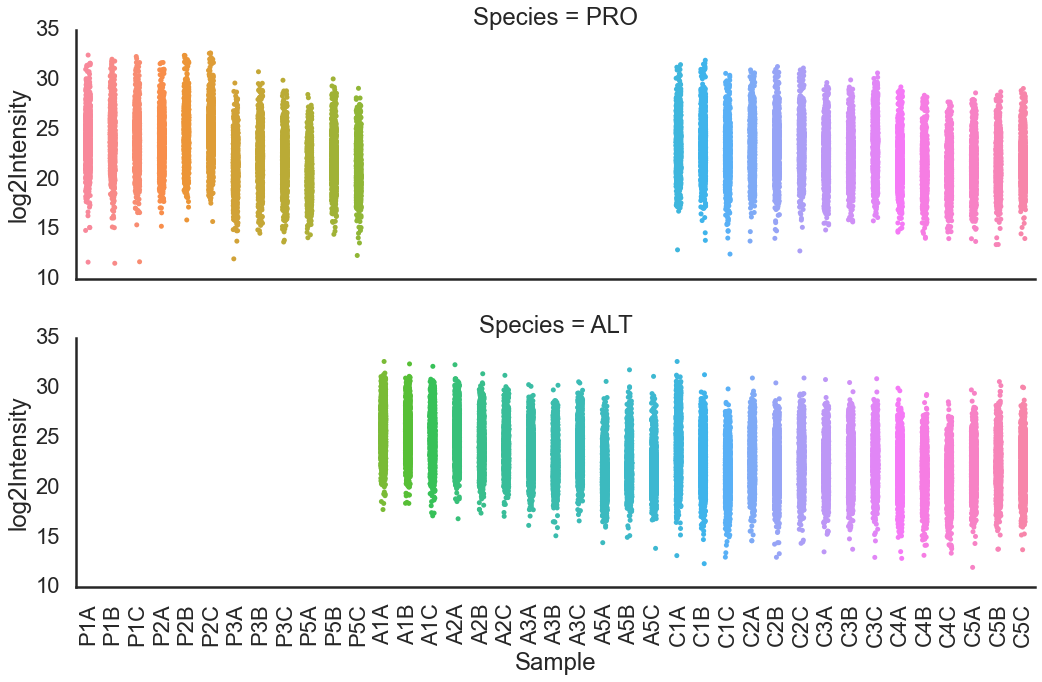

In [34]:
sns.catplot(data=mdf.loc[mdf.found_protein],
            y='log2Intensity', x='Sample', row='Species',
            #kind='bar', 
            aspect=3
           ).set_xticklabels(rotation=90)
plt.tight_layout()

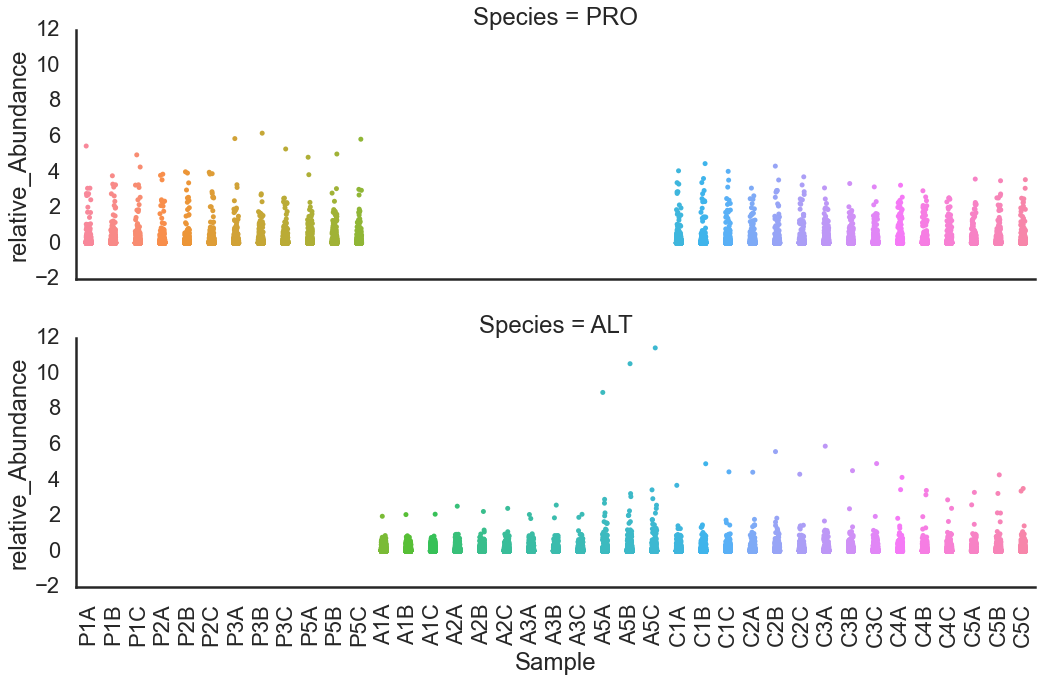

In [35]:
sns.catplot(data=mdf.loc[mdf.found_protein],
            y='relative_Abundance', x='Sample', row='Species',
            #kind='bar', 
            aspect=3
           ).set_xticklabels(rotation=90)
plt.tight_layout()

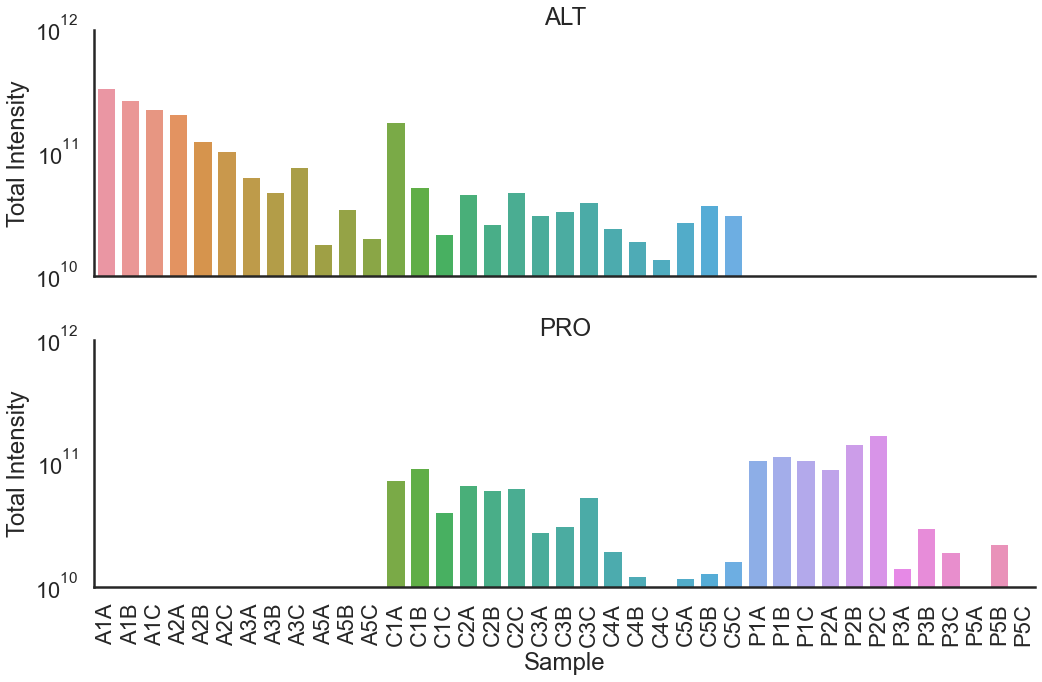

In [36]:
tot_intensity_df = mdf.groupby(['found_protein', 'Species', 'Sample'])['Intensity'].sum().reset_index()
sns.catplot(data=tot_intensity_df.loc[tot_intensity_df.found_protein],
            y='Intensity', x='Sample', row='Species',
            kind='bar', 
            aspect=3
           ).set_xticklabels(rotation=90).set(yscale='log', ylabel='Total Intensity').set_titles('{row_name}')
plt.tight_layout()

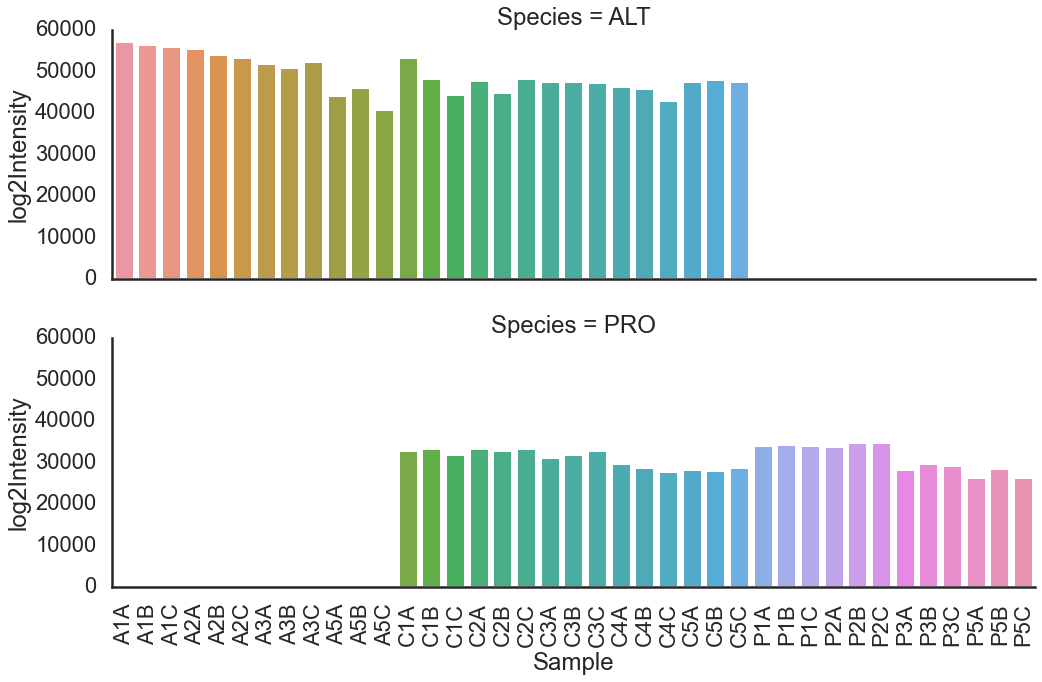

In [37]:
tot_intensity_df = mdf.groupby(['found_protein', 'Species', 'Sample'])['log2Intensity'].sum().reset_index()
sns.catplot(data=tot_intensity_df.loc[tot_intensity_df.found_protein],
            y='log2Intensity', x='Sample', row='Species',
            kind='bar', 
            aspect=3
           ).set_xticklabels(rotation=90)
plt.tight_layout()

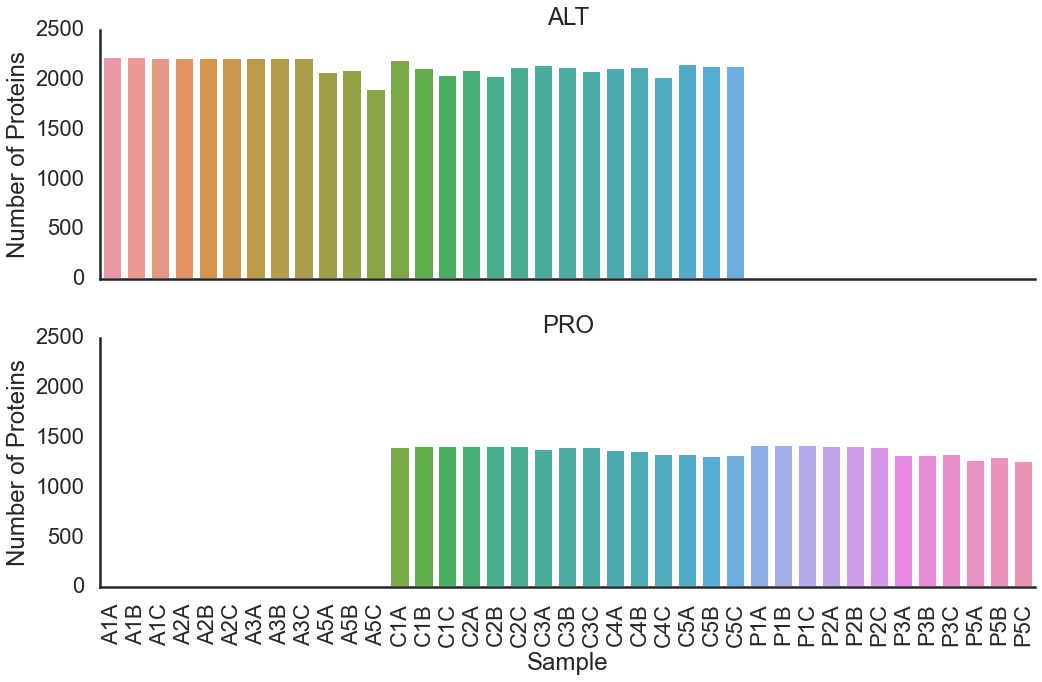

In [38]:
found_protein_desc_df =  mdf.groupby(['found_protein', 'Species', 'Sample'])['Intensity'].describe().reset_index()
sns.catplot(data=found_protein_desc_df.loc[tot_intensity_df.found_protein],
            y='count', x='Sample', row='Species',
            kind='bar', 
            aspect=3
           ).set_xticklabels(rotation=90).set(ylabel='Number of Proteins').set_titles('{row_name}')

plt.tight_layout()

In [39]:
mdf.head()

,index,Protein Accession,Gene,Organism,Protein Full Name,Unique Peptides,Sequence Coverage,Protein Decoy/Contaminant/Target,Number of Peptides,Number of Unique Peptides,...,timepoint,replicate,ff,culture,Valid,cculture,viable_sample,found_protein,log2Intensity,relative_Abundance
0,0,WP_011133152.1 photosystem I core protein PsaA...,NaN,NaN,NaN,EILDSQQGDPILFPAPK|AISEVFNGSLVEVGGK|AISEVFN[Com...,mTISPPESGEKDKKILESPVKADPRPIDFAKLDKPGFWSSKlskgp...,T,105,105,...,1,A,med4 (AX),PRO Axenic,Valid,Axenic,True,True,31.623819,3.084305
1,1,WP_011132825.1 polyribonucleotide nucleotidylt...,NaN,NaN,NaN,IDIEDGGIVTIASHDGAAAEEAQK|DLELDKIELEVQTK|VGLIGD...,megkNTSITFDGREIRLTTGLYAPQAGGAVMIECGDTSLLVTATKt...,T,222,222,...,1,A,med4 (AX),PRO Axenic,Valid,Axenic,True,True,28.370006,0.323342
2,2,WP_011132757.1 autotransporter outer membrane ...,NaN,NaN,NaN,AGVAYGVGSSNLNNYNFSSTTASLSSTNTHYSIYGVK|GM[Commo...,mkiynfllltlifsslpikagenfsgnfdvnnwstvgssgdgsldt...,T,17,17,...,1,A,med4 (AX),PRO Axenic,Valid,Axenic,True,True,24.639000,0.024351
3,3,WP_011132404.1 NADP-dependent phosphogluconate...,NaN,NaN,NaN,AGAATDAVIDNISEYLEEGDLLIDGGNSQFKDTER|AGAATDAVID...,mpkAHFGLIGLGVMGENLVLNAERNGFSSVVFNRTYSKTQEFLEGR...,T,56,56,...,1,A,med4 (AX),PRO Axenic,Valid,Axenic,True,True,26.100791,0.067075
4,4,WP_011132401.1 class II fructose-bisphosphatas...,NaN,NaN,NaN,ALGGHFQGQLVYDPAIAQTSEWADYTK|LTGLGQKDEADAAAVEAM...,MNQTLIQEILEVVEQAAIASAKLTGLGQKDEADAAAVEAMRLRmgk...,T,99,99,...,1,A,med4 (AX),PRO Axenic,Valid,Axenic,True,True,27.975969,0.246062


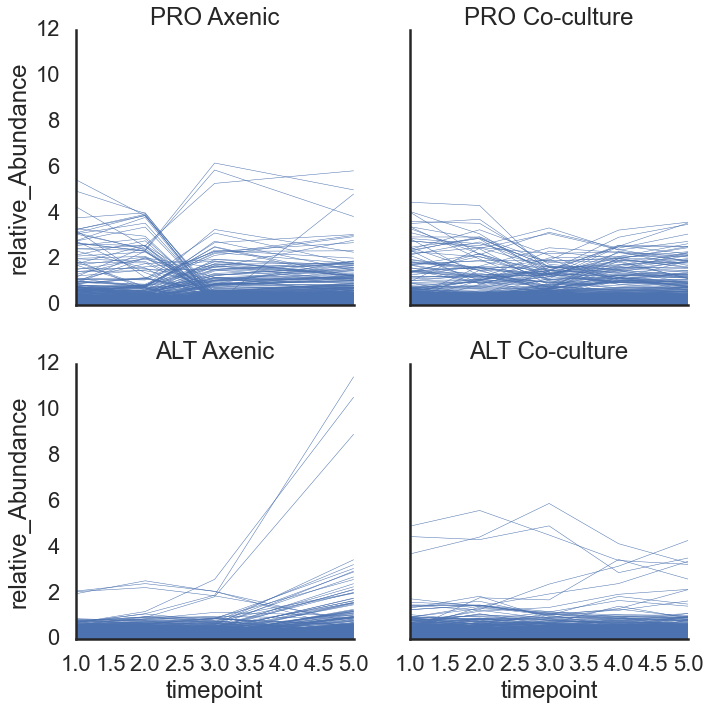

In [40]:
mdf['replicate_Protein_Accession'] = mdf['Protein Accession'] + mdf['replicate']
sns.relplot(
    data=mdf.loc[mdf.found_protein], x='timepoint', y='relative_Abundance',
    row='Species', 
    col='cculture',# col_wrap=2,
    kind='line', 
    estimator=None, units='replicate_Protein_Accession', lw=0.5,
).set_titles('{row_name} {col_name}')

In [41]:
high_abundance_proteins = mdf.loc[mdf.found_protein & (mdf['relative_Abundance']>=2) & mdf.viable_sample]['Protein Accession'].unique()

In [52]:
'"' +'","'.join(mdf.loc[mdf.found_protein & (mdf['relative_Abundance']>=2) & mdf.viable_sample]['protein_id'].unique()) + '""'

'"WP_011133152.1","WP_011133065.1","WP_011131952.1","WP_002805854.1","WP_011132792.1","WP_011133147.1","WP_011133151.1","WP_011132791.1","WP_011131862.1","WP_036930312.1","WP_011132261.1","WP_011132117.1","WP_014977498.1","WP_061485087.1","WP_011133067.1","WP_011132043.1","WP_011133080.1","WP_011132415.1","WP_011819929.1","WP_011133066.1","WP_014950040.1","WP_014951106.1""'

In [42]:
high_abundance_proteins

array(['WP_011133152.1 photosystem I core protein PsaA [Prochlorococcus marinus]',
       'WP_011133065.1 chaperonin GroEL [Prochlorococcus marinus]',
       'WP_011131952.1 photosystem II chlorophyll-binding protein CP47 [Prochlorococcus marinus]',
       'WP_002805854.1 MULTISPECIES: form I ribulose bisphosphate carboxylase large subunit [Prochlorococcus]',
       'WP_011132792.1 photosystem II reaction center protein CP43 [Prochlorococcus marinus]',
       'WP_011133147.1 photosystem I reaction center protein subunit XI [Prochlorococcus marinus]',
       'WP_011133151.1 photosystem I core protein PsaB [Prochlorococcus marinus]',
       'WP_011132791.1 photosystem II D2 protein (photosystem q(a) protein) [Prochlorococcus marinus]',
       'WP_011131862.1 photosystem II q(b) protein [Prochlorococcus marinus]',
       'WP_036930312.1 urea ABC transporter substrate-binding protein [Prochlorococcus marinus]',
       'WP_011132261.1 chlorophyll a/b binding light-harvesting protein [Prochl

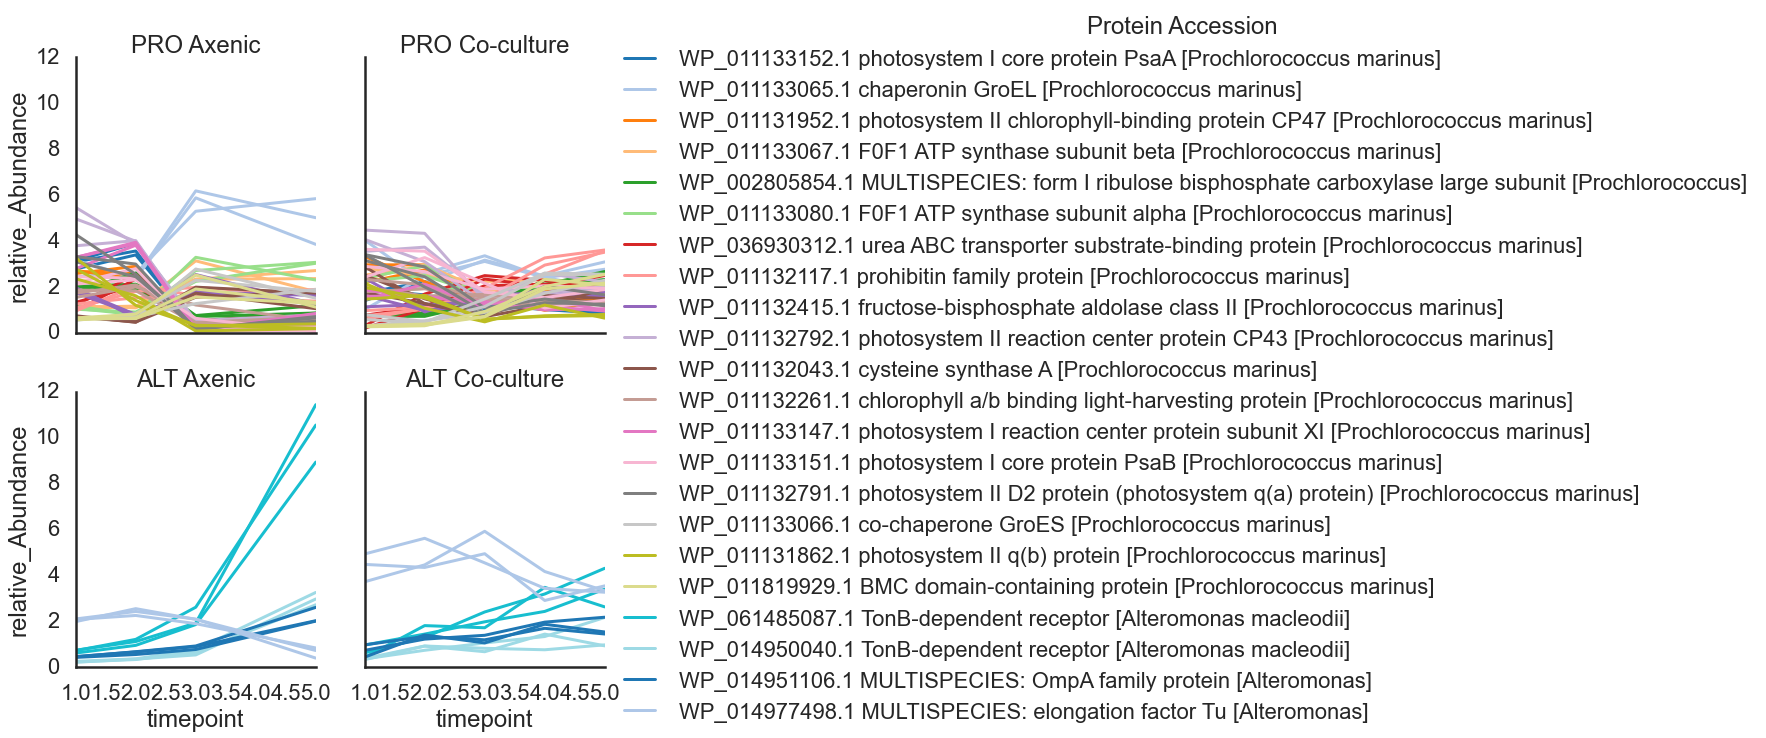

In [43]:
mdf['replicate_Protein_Accession'] = mdf['Protein Accession'] + mdf['replicate']
sns.relplot(
    data=mdf.loc[mdf.found_protein & mdf['Protein Accession'].isin(high_abundance_proteins)], x='timepoint', y='relative_Abundance',
    row='Species', 
    col='cculture',# col_wrap=2,
    kind='line', 
    hue='Protein Accession', palette='tab20',
    estimator=None, units='replicate_Protein_Accession', 
).set_titles('{row_name} {col_name}')

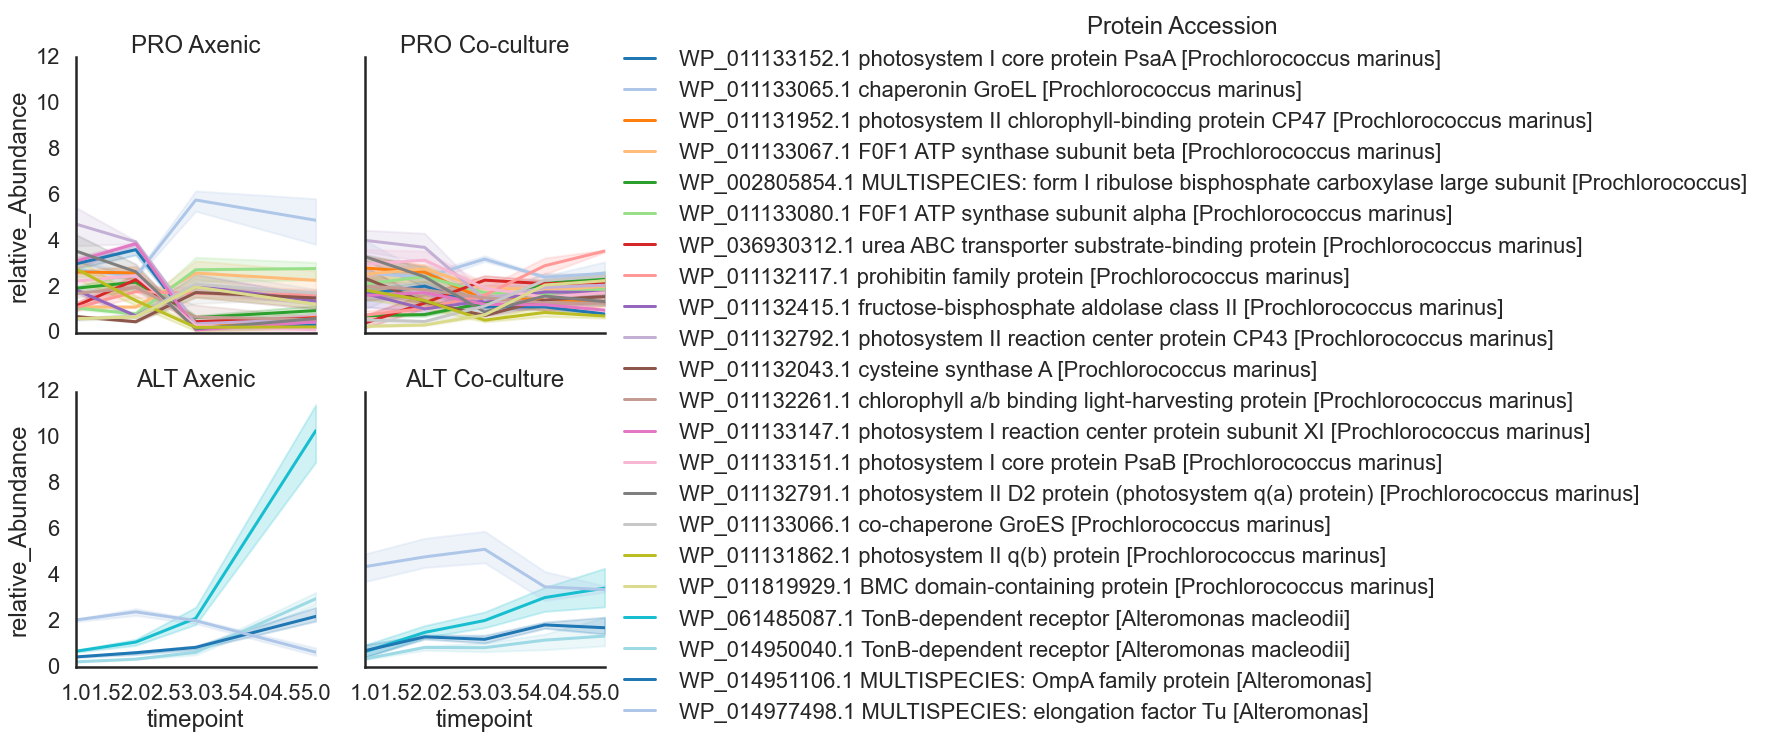

In [44]:
sns.relplot(
    data=mdf.loc[mdf.found_protein & mdf['Protein Accession'].isin(high_abundance_proteins)], x='timepoint', y='relative_Abundance',
    row='Species', 
    col='cculture',# col_wrap=2,
    kind='line', 
    hue='Protein Accession', palette='tab20',
    #estimator=None, units='Protein Accession', 
).set_titles('{row_name} {col_name}')

In [32]:
size_df = mdf.groupby([ 'Species', 'Sample',  'Group', 'culture',
       'timepoint', 'ff', 'Valid']).size().reset_index().rename(columns={0:'count'})

In [33]:
size_df.head()

,Species,Sample,Group,culture,timepoint,ff,Valid,count
0,ALT,A1A,A,ALT Axenic,1,1A3 (AX),Valid,2945
1,ALT,A1B,A,ALT Axenic,1,1A3 (AX),Valid,2952
2,ALT,A1C,A,ALT Axenic,1,1A3 (AX),Valid,2934
3,ALT,A2A,A,ALT Axenic,2,1A3 (AX),Valid,2921
4,ALT,A2B,A,ALT Axenic,2,1A3 (AX),Valid,2891


Text(0.5, 1.1, 'Number of Proteins')

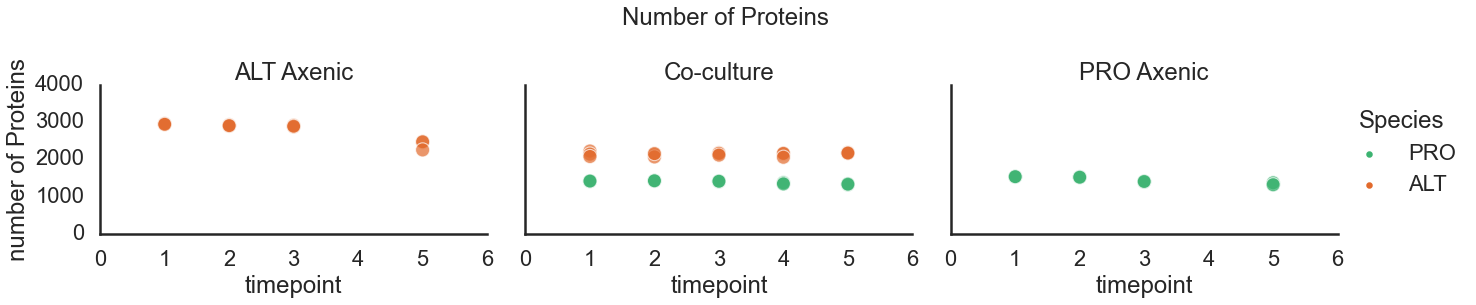

In [34]:
sns.relplot(data=size_df, 
            hue='Species', palette=gpal, hue_order=gorder,
            x='timepoint', y='count', 
            height=4, aspect=1.6, s=200, #style='Valid',
            alpha=0.7, col='culture',
           ).set_titles(col_template='{col_name}').set(ylabel='number of Proteins', yticks=[0,1000,2000,3000,4000])
plt.suptitle('Number of Proteins', y=1.1)           

In [35]:
psize_df = size_df.pivot_table(values='count', index=['culture','Sample', 'timepoint'], columns='Species').reset_index()
psize_df

Species,culture,Sample,timepoint,ALT,PRO
0,ALT Axenic,A1A,1,2945.0,NaN
1,ALT Axenic,A1B,1,2952.0,NaN
2,ALT Axenic,A1C,1,2934.0,NaN
3,ALT Axenic,A2A,2,2921.0,NaN
4,ALT Axenic,A2B,2,2891.0,NaN
5,ALT Axenic,A2C,2,2902.0,NaN
6,ALT Axenic,A3A,3,2909.0,NaN
7,ALT Axenic,A3B,3,2869.0,NaN
8,ALT Axenic,A3C,3,2886.0,NaN
9,ALT Axenic,A5A,5,2456.0,NaN


Text(0.5, 1.1, 'Number of Proteins')

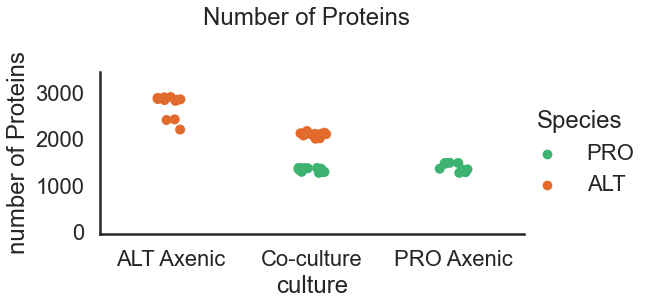

In [36]:
sns.catplot(data=size_df, 
            hue='Species', palette=gpal, hue_order=gorder,
            x='culture', 
            y='count', 
            height=4, aspect=2, s=10, #style='Valid',
            edgecolor='white',lw=1,
            #alpha=0.7, 
            #kind='box',
           ).set_titles(col_template='{col_name}').set(ylabel='number of Proteins', yticks=[0,1000,2000,3000])
plt.suptitle('Number of Proteins', y=1.1)           

Text(0.5, 1.1, 'Number of Proteins')

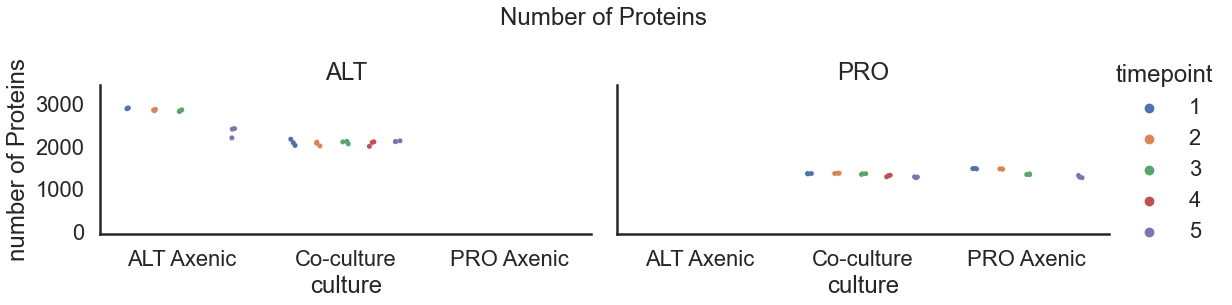

In [37]:
sns.catplot(data=size_df, 
            col='Species', hue='timepoint', # palette=gpal, hue_order=gorder,
            x='culture', 
            y='count', 
            height=4, aspect=2, #s=10, #style='Valid',
            edgecolor='white',lw=1, dodge=True,
            #alpha=0.7, 
            #kind='box',
           ).set_titles(col_template='{col_name}').set(ylabel='number of Proteins', yticks=[0,1000,2000,3000])
plt.suptitle('Number of Proteins', y=1.1)           

In [38]:
psize_df.culture.unique()

array(['ALT Axenic', 'Co-culture', 'PRO Axenic'], dtype=object)

Text(0.5, 1.1, 'number of proteins - current extraction')

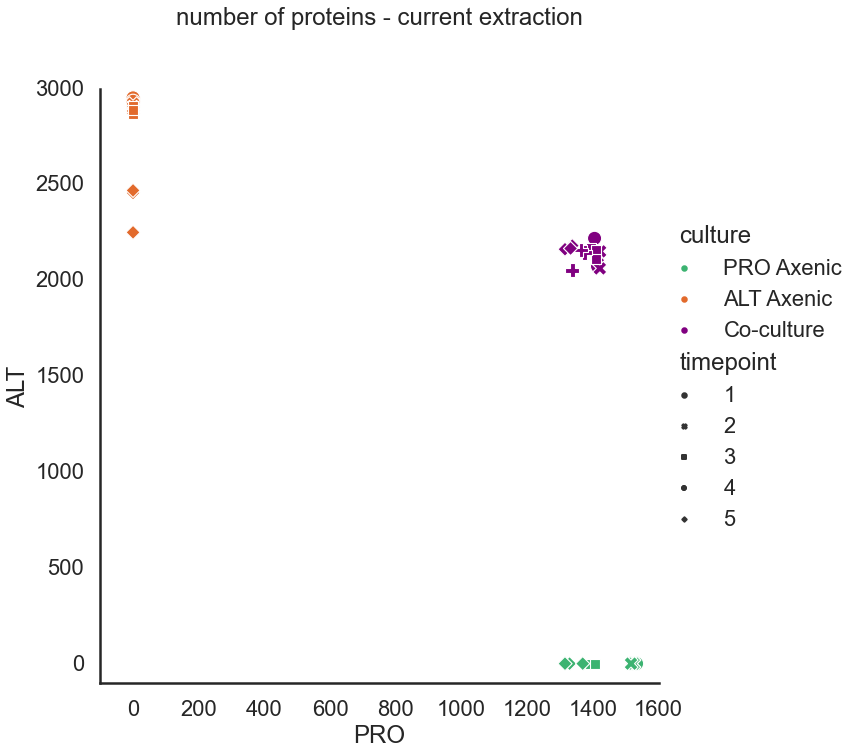

In [39]:
sns.set_context('poster')
sns.relplot(data=psize_df.fillna(0), 
                x='PRO', y='ALT', s=200, hue='culture', style='timepoint',
            height=10, hue_order=['PRO Axenic', 'ALT Axenic', 'Co-culture', ], palette=gpal+['purple'],
           ).set(xlim=(-100,1600), ylim=(-100,3000))
plt.title('number of proteins - current extraction', y=1.1)

In [40]:
tpal

['#aad5aa', 'MediumSeaGreen']

In [41]:
timepal = sns.color_palette("dark:#7978FF_r", n_colors=5).as_hex()
timepal = sns.color_palette("ocean_r", n_colors=5).as_hex()
#timepal = sns.color_palette("dark:Blue_r", n_colors=5).as_hex()

In [42]:
sns.color_palette("ocean", n_colors=5)


[(0.0, 0.2529411764705882, 0.16470588235294117),
 (0.0, 0.0, 0.3333333333333333),
 (0.0, 0.2529411764705882, 0.5019607843137255),
 (0.0, 0.5, 0.6666666666666666),
 (0.5058823529411764, 0.7529411764705882, 0.8352941176470589)]

Text(0.5, 1.1, 'number of proteins - co-culture')

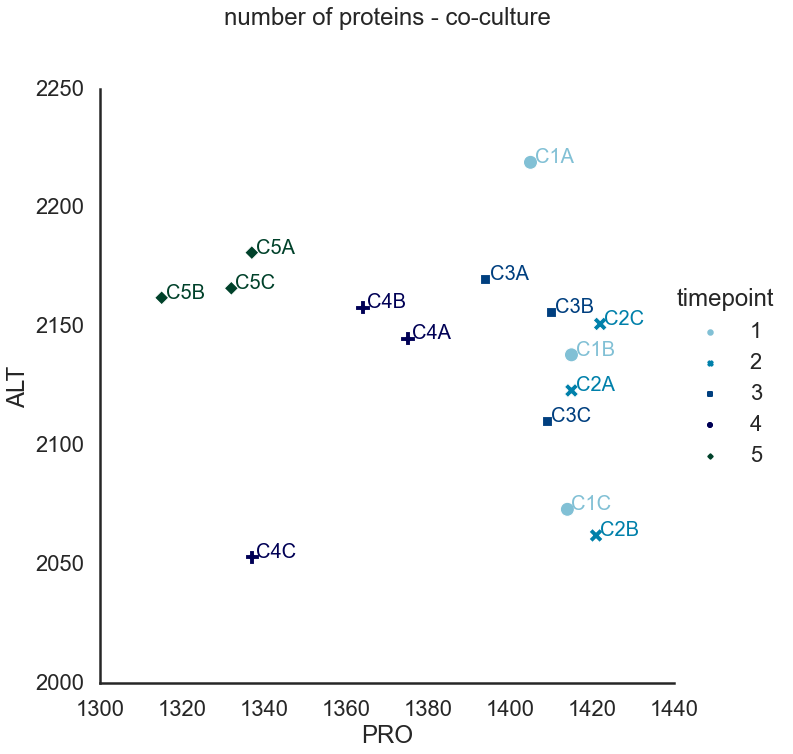

In [43]:
sns.set_context('poster')
tdf = psize_df.fillna(0).loc[psize_df.culture.isin(['Co-culture'])]
p1 = sns.relplot(data=tdf, 
                x='PRO', y='ALT', s=200, hue='timepoint', style='timepoint',
                 palette=timepal,
            height=10, 
            #hue_order=['ALT Axenic', 'PRO Axenic', 'Co-culture', ], palette=gpal+['purple'],
           )# .set(xlim=(-10,1600), ylim=(-10,3000))
for line in tdf.iterrows():
     line= line[1]
     #print(line)
     p1.ax.text(line['PRO']+1, line['ALT'], 
     line['Sample'], horizontalalignment='left', 
     size='small', color=timepal[line['timepoint']-1]), #weight='semibold')
plt.title('number of proteins - co-culture', y=1.1)

Text(0.5, 1.1, 'Intensity Histogram')

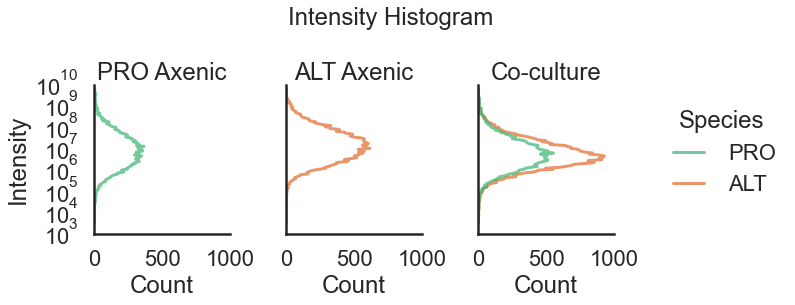

In [44]:
sns.set_context('poster')
sns.displot(data=mdf.loc[mdf.found_protein], y='Intensity', 
            #col='timepoint',  
            fill=False, element='poly',
            hue='Species', palette=gpal, hue_order=gorder,
            log_scale=True,
            height=4, aspect=0.8, 
            alpha=0.7, col='culture',
           ).set_titles(col_template='{col_name}').set(xticks=[0,500,1000])            
plt.suptitle('Intensity Histogram', y=1.1)           

Text(0.5, 1.1, 'Intensity Histogram')

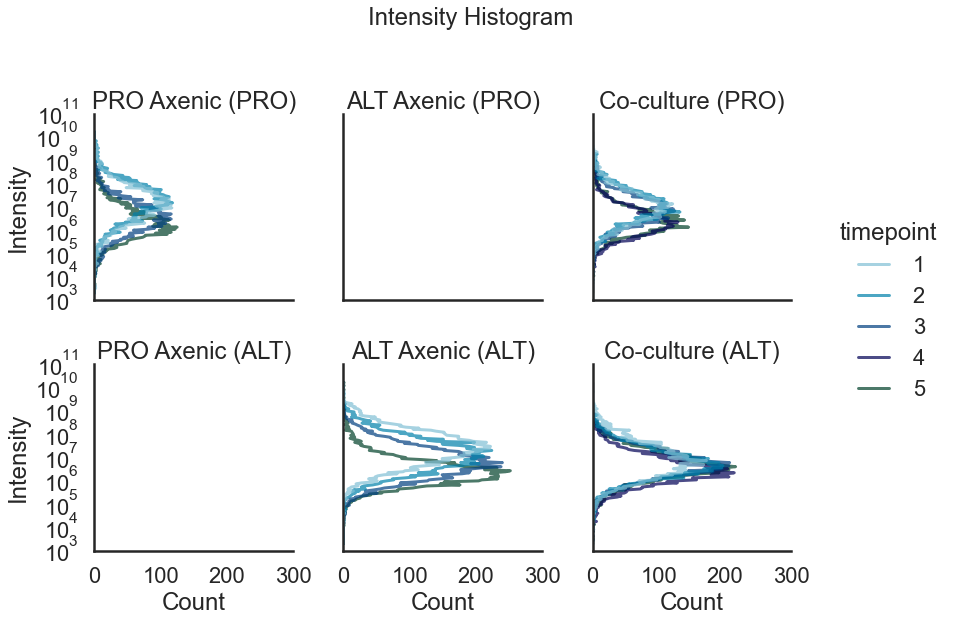

In [45]:
sns.displot(data=mdf, y='Intensity', 
            #col='timepoint',  
            fill=False, element='poly',
            #hue='Species', palette=gpal, hue_order=gorder,
            hue='timepoint', palette=timepal, # hue_order=torder,
            log_scale=True,
            height=4, aspect=1, 
            alpha=0.7, col='culture',
            row='Species'
           ).set_titles(template='{col_name} ({row_name})').set(xticks=[0,100,200, 300])            
plt.suptitle('Intensity Histogram', y=1.1)           

In [46]:
mdf.loc[mdf.ff.isin(['1A3 (AX PRO)'])]

,index,Protein Accession,Gene,Organism,Protein Full Name,Unique Peptides,Sequence Coverage,Protein Decoy/Contaminant/Target,Number of Peptides,Number of Unique Peptides,...,Group,timepoint,replicate,ff,culture,Valid,viable_sample,found_protein,log2Intensity,normIntensity


In [47]:
mdf.groupby(['Group', 'Species']).Intensity.describe()

count          mean           std           min  \
Group Species                                                      
A     ALT      33384.0  4.808094e+07  1.983638e+08  12810.856445   
C     ALT      32067.0  1.977220e+07  8.132056e+07   1912.990601   
      PRO      20765.0  2.851672e+07  1.245279e+08   5702.240234   
P     PRO      17348.0  4.838062e+07  2.454786e+08   3006.950195   

                        25%        50%         75%           max  
Group Species                                                     
A     ALT      2.396117e+06  8167838.0  31067631.0  1.732217e+10  
C     ALT      1.792038e+06  4599367.0  13434741.5  6.562808e+09  
      PRO      1.708456e+06  5152180.0  16136442.0  4.085199e+09  
P     PRO      1.666475e+06  6420511.0  24840358.0  6.767466e+09

In [48]:
mdf.head()

,index,Protein Accession,Gene,Organism,Protein Full Name,Unique Peptides,Sequence Coverage,Protein Decoy/Contaminant/Target,Number of Peptides,Number of Unique Peptides,...,Group,timepoint,replicate,ff,culture,Valid,viable_sample,found_protein,log2Intensity,normIntensity
0,0,WP_011133152.1 photosystem I core protein PsaA...,NaN,NaN,NaN,EILDSQQGDPILFPAPK|AISEVFNGSLVEVGGK|AISEVFN[Com...,mTISPPESGEKDKKILESPVKADPRPIDFAKLDKPGFWSSKlskgp...,T,105,105,...,P,1,A,med4 (AX),PRO Axenic,Valid,True,True,31.623819,0.030843
1,1,WP_011132825.1 polyribonucleotide nucleotidylt...,NaN,NaN,NaN,IDIEDGGIVTIASHDGAAAEEAQK|DLELDKIELEVQTK|VGLIGD...,megkNTSITFDGREIRLTTGLYAPQAGGAVMIECGDTSLLVTATKt...,T,222,222,...,P,1,A,med4 (AX),PRO Axenic,Valid,True,True,28.370006,0.003233
2,2,WP_011132757.1 autotransporter outer membrane ...,NaN,NaN,NaN,AGVAYGVGSSNLNNYNFSSTTASLSSTNTHYSIYGVK|GM[Commo...,mkiynfllltlifsslpikagenfsgnfdvnnwstvgssgdgsldt...,T,17,17,...,P,1,A,med4 (AX),PRO Axenic,Valid,True,True,24.639000,0.000244
3,3,WP_011132404.1 NADP-dependent phosphogluconate...,NaN,NaN,NaN,AGAATDAVIDNISEYLEEGDLLIDGGNSQFKDTER|AGAATDAVID...,mpkAHFGLIGLGVMGENLVLNAERNGFSSVVFNRTYSKTQEFLEGR...,T,56,56,...,P,1,A,med4 (AX),PRO Axenic,Valid,True,True,26.100791,0.000671
4,4,WP_011132401.1 class II fructose-bisphosphatas...,NaN,NaN,NaN,ALGGHFQGQLVYDPAIAQTSEWADYTK|LTGLGQKDEADAAAVEAM...,MNQTLIQEILEVVEQAAIASAKLTGLGQKDEADAAAVEAMRLRmgk...,T,99,99,...,P,1,A,med4 (AX),PRO Axenic,Valid,True,True,27.975969,0.002461


In [49]:
d = deseq_df.drop_duplicates('protein_id')
smap = d['sub']
smap.index = d['protein_id']

In [50]:
mdf['protein_id'] = mdf['Protein Accession'].str.split(expand=True)[0]
mdf['protein_group'] = mdf['protein_id'].map(smap)

mdf.loc[mdf['protein_group'].str.contains('Poorly characterized', na=False), 'Category'] = 'Poorly characterized'
mdf.loc[mdf['protein_group'].str.contains('metabolism', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('genetic information', na=False), 'Category'] = 'genetic info'
mdf.loc[mdf['protein_group'].str.contains('Signal transduction', na=False), 'Category'] = 'signaling'
mdf.loc[mdf['protein_group'].str.contains('signaling and cellular processes', na=False), 'Category'] = 'signaling'
mdf.loc[mdf['protein_group'].str.contains('Energy metabolism', na=False), 'Category'] = 'Energy'
mdf.loc[mdf['protein_group'].str.contains('Metabolism of terpenoids and polyketides', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('cofactors and vitamins', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('Nucleotide metabolism', na=False), 'Category'] = 'Nucleotide'
mdf.loc[mdf['protein_group'].str.contains('Carbohydrate metabolism', na=False), 'Category'] = 'Carbohydrate'
mdf.loc[mdf['protein_group'].str.contains('Lipid metabolism', na=False), 'Category'] = 'Lipid'
mdf.loc[mdf['protein_group'].str.contains('Glycan biosynthesis and metabolism', na=False), 'Category'] = 'Carbohydrate'
mdf.loc[mdf['protein_group'].str.contains('Amino acid metabolism', na=False), 'Category'] = 'Amino acid'
mdf.loc[mdf['protein_group'].str.contains('Metabolism of other amino acids', na=False), 'Category'] = 'Amino acid'



In [51]:
mdf['Category'] = np.NaN

In [52]:
mdf['protein_id'] = mdf['Protein Accession'].str.split(expand=True)[0]
mdf['protein_group'] = mdf['protein_id'].map(smap)

#mdf.loc[mdf['protein_group'].str.contains('Poorly characterized', na=False), 'Category'] = 'Poorly characterized'
mdf.loc[mdf['protein_group'].str.contains('metabolism', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('genetic information', na=False), 'Category'] = 'genetic info'
mdf.loc[mdf['protein_group'].str.contains('Signal transduction', na=False), 'Category'] = 'signaling'
mdf.loc[mdf['protein_group'].str.contains('signaling and cellular processes', na=False), 'Category'] = 'signaling'
mdf.loc[mdf['protein_group'].str.contains('Energy metabolism', na=False), 'Category'] = 'Energy & Carbohydrate'
mdf.loc[mdf['protein_group'].str.contains('Metabolism of terpenoids and polyketides', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('cofactors and vitamins', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('Nucleotide metabolism', na=False), 'Category'] = 'Amino acid & Nucleotide & Lipid'
mdf.loc[mdf['protein_group'].str.contains('Carbohydrate metabolism', na=False), 'Category'] = 'Energy & Carbohydrate'
mdf.loc[mdf['protein_group'].str.contains('Lipid metabolism', na=False), 'Category'] = 'Amino acid & Nucleotide & Lipid'
mdf.loc[mdf['protein_group'].str.contains('Glycan biosynthesis and metabolism', na=False), 'Category'] = 'Energy & Carbohydrate'
mdf.loc[mdf['protein_group'].str.contains('Amino acid metabolism', na=False), 'Category'] = 'Amino acid & Nucleotide & Lipid'
mdf.loc[mdf['protein_group'].str.contains('Metabolism of other amino acids', na=False), 'Category'] = 'Amino acid & Nucleotide & Lipid'



In [53]:
plut_map = {'P': PCOLOR_light, 'C' :PRO_COLOR}
alut_map = {'A': HCOLOR_light, 'C' :HCOLOR}


C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1, 'MED4 proteins (log2(Intensity))')

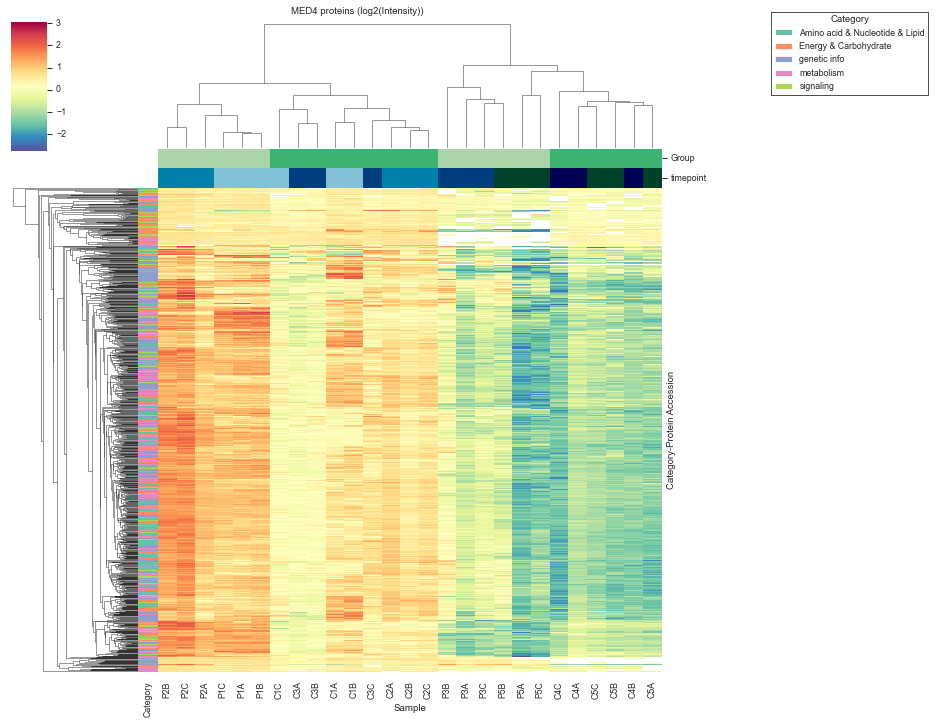

In [54]:
from matplotlib.patches import Patch
sns.set_context('paper')
pdf = mdf.loc[mdf.Species.isin(['PRO'])& mdf.found_protein].pivot_table(values='log2Intensity', fill_value=0, 
                                                     index=['Category','Protein Accession'], columns='Sample' )
col_anno = pd.DataFrame(pdf.columns.to_list())
col_anno.index= col_anno[0]
col_anno['Group']=col_anno[0].str.get(0)
col_anno['timepoint']=pd.to_numeric(col_anno[0].str.get(1))
cols=['Group', 'timepoint']
col_anno['Group'] = col_anno['Group'].map(plut_map)
col_anno['timepoint'] = col_anno['timepoint'].map(dict(zip([1,2,3,4,5], timepal)))

glut = dict(zip(pdf.index.get_level_values(0).unique(), sns.color_palette('Set2')))
row_anno = pdf.index.get_level_values(0).to_series().reset_index(drop=True).map(glut)
row_anno.index = pdf.index

sns.clustermap(pdf, yticklabels=False, cmap='Spectral_r', mask=(pdf==0), 
               col_colors=col_anno[cols],
               row_colors=row_anno,
               #row_cluster=False,
               z_score=0,
              #               colors_ratio=1,
              )
handles = [Patch(facecolor=glut[name]) for name in glut]
plt.legend(handles, glut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('MED4 proteins (log2(Intensity))', y=1)

C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1, 'MED4 proteins (log2(Intensity))')

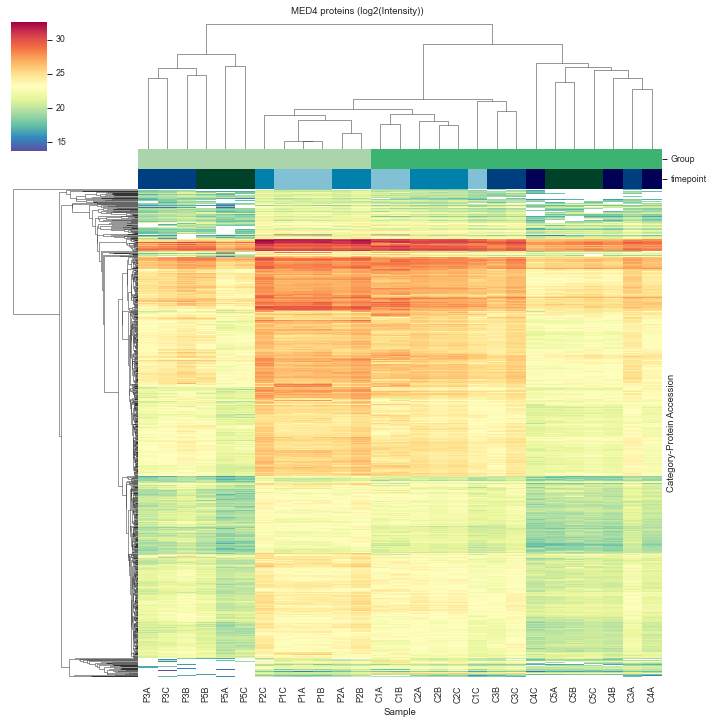

In [55]:
from matplotlib.patches import Patch
sns.set_context('paper')
pdf = mdf.loc[mdf.Species.isin(['PRO']) & mdf.found_protein].pivot_table(values='log2Intensity', fill_value=0, 
                                                     index=['Category','Protein Accession'], columns='Sample' )
col_anno = pd.DataFrame(pdf.columns.to_list())
col_anno.index= col_anno[0]
col_anno['Group']=col_anno[0].str.get(0)
col_anno['timepoint']=pd.to_numeric(col_anno[0].str.get(1))
cols=['Group', 'timepoint']
col_anno['Group'] = col_anno['Group'].map(plut_map)
col_anno['timepoint'] = col_anno['timepoint'].map(dict(zip([1,2,3,4,5], timepal)))


sns.clustermap(pdf, yticklabels=False, cmap='Spectral_r', mask=(pdf==0), 
               col_colors=col_anno[cols],
              )
# handles = [Patch(facecolor=plut_map[name]) for name in plut_map]
# plt.legend(handles, plut_map, title='Group',
#            bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('MED4 proteins (log2(Intensity))', y=1)

C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1, 'MED4 proteins (log2(Intensity))')

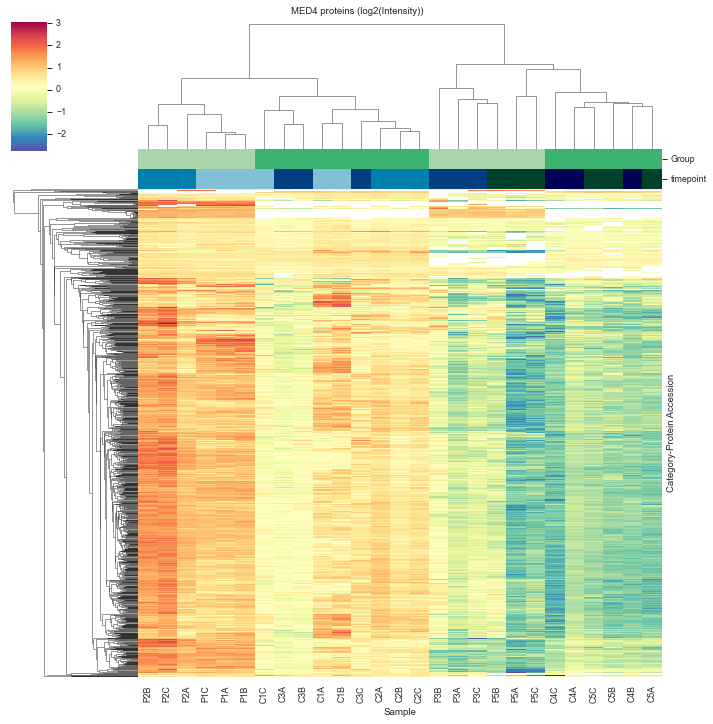

In [56]:
from matplotlib.patches import Patch
sns.set_context('paper')
pdf = mdf.loc[mdf.Species.isin(['PRO'])].pivot_table(values='log2Intensity', fill_value=0, 
                                                     index=['Category','Protein Accession'], columns='Sample' )
col_anno = pd.DataFrame(pdf.columns.to_list())
col_anno.index= col_anno[0]
col_anno['Group']=col_anno[0].str.get(0)
col_anno['timepoint']=pd.to_numeric(col_anno[0].str.get(1))
cols=['Group', 'timepoint']
col_anno['Group'] = col_anno['Group'].map(plut_map)
col_anno['timepoint'] = col_anno['timepoint'].map(dict(zip([1,2,3,4,5], timepal)))


sns.clustermap(pdf, yticklabels=False, cmap='Spectral_r', mask=(pdf==0), 
               col_colors=col_anno[cols], 
               z_score =0,
              )
# handles = [Patch(facecolor=plut_map[name]) for name in plut_map]
# plt.legend(handles, plut_map, title='Group',
#            bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('MED4 proteins (log2(Intensity))', y=1)

In [57]:
mdf['protein_id'] = mdf['Protein Accession'].str.split(expand=True)[0]
mdf['protein_group'] = mdf['protein_id'].map(smap)

mdf.loc[mdf['protein_group'].str.contains('Poorly characterized', na=False), 'Category'] = 'Poorly characterized'
mdf.loc[mdf['protein_group'].str.contains('metabolism', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('genetic information', na=False), 'Category'] = 'genetic info'
mdf.loc[mdf['protein_group'].str.contains('Signal transduction', na=False), 'Category'] = 'signaling'
mdf.loc[mdf['protein_group'].str.contains('signaling and cellular processes', na=False), 'Category'] = 'signaling'
mdf.loc[mdf['protein_group'].str.contains('Energy metabolism', na=False), 'Category'] = 'Energy'
mdf.loc[mdf['protein_group'].str.contains('Metabolism of terpenoids and polyketides', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('cofactors and vitamins', na=False), 'Category'] = 'metabolism'
mdf.loc[mdf['protein_group'].str.contains('Nucleotide metabolism', na=False), 'Category'] = 'Nucleotide'
mdf.loc[mdf['protein_group'].str.contains('Carbohydrate metabolism', na=False), 'Category'] = 'Carbohydrate'
mdf.loc[mdf['protein_group'].str.contains('Lipid metabolism', na=False), 'Category'] = 'Lipid'
mdf.loc[mdf['protein_group'].str.contains('Glycan biosynthesis and metabolism', na=False), 'Category'] = 'Carbohydrate'
mdf.loc[mdf['protein_group'].str.contains('Amino acid metabolism', na=False), 'Category'] = 'Amino acid'
mdf.loc[mdf['protein_group'].str.contains('Metabolism of other amino acids', na=False), 'Category'] = 'Amino acid'



In [58]:
pdf.index.get_level_values(0).to_series().reset_index(drop=True).map(glut)

0          (0.4, 0.7607843137254902, 0.6470588235294118)
1          (0.4, 0.7607843137254902, 0.6470588235294118)
2          (0.4, 0.7607843137254902, 0.6470588235294118)
3          (0.4, 0.7607843137254902, 0.6470588235294118)
4          (0.4, 0.7607843137254902, 0.6470588235294118)
                             ...                        
918    (0.6509803921568628, 0.8470588235294118, 0.329...
919    (0.6509803921568628, 0.8470588235294118, 0.329...
920    (0.6509803921568628, 0.8470588235294118, 0.329...
921    (0.6509803921568628, 0.8470588235294118, 0.329...
922    (0.6509803921568628, 0.8470588235294118, 0.329...
Name: Category, Length: 923, dtype: object

In [59]:
col_anno = pd.DataFrame(pdf.columns.to_series())
col_anno.columns
# col_anno.index= col_anno
# col_anno['Group']=col_anno[0].str.get(0)
# col_anno['timepoint']=pd.to_numeric(col_anno[0].str.get(1))
# plut_map = {'P': PCOLOR_light, 'C' :PRO_COLOR}
# alut_map = {'A': HCOLOR_light, 'C' :HCOLOR}
# cols=['Group', 'timepoint']
# col_anno['Group'] = col_anno['Group'].map(plut_map)
# col_anno['timepoint'] = col_anno['timepoint'].map(dict(zip([1,2,3,4,5], sns.color_palette("dark:salmon_r", n_colors=5).as_hex())))
# col_anno


Index(['Sample'], dtype='object')

In [60]:
col_anno = pd.DataFrame(pdf.columns.to_series())
col_anno.columns
# col_anno.index= col_anno
# col_anno['Group']=col_anno[0].str.get(0)
# col_anno['timepoint']=pd.to_numeric(col_anno[0].str.get(1))
# plut_map = {'P': PCOLOR_light, 'C' :PRO_COLOR}
# alut_map = {'A': HCOLOR_light, 'C' :HCOLOR}
# cols=['Group', 'timepoint']
# col_anno['Group'] = col_anno['Group'].map(plut_map)
# col_anno['timepoint'] = col_anno['timepoint'].map(dict(zip([1,2,3,4,5], sns.color_palette("dark:salmon_r", n_colors=5).as_hex())))
# col_anno


Index(['Sample'], dtype='object')

C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1, 'HOT1A3 proteins (log2(Intensity))')

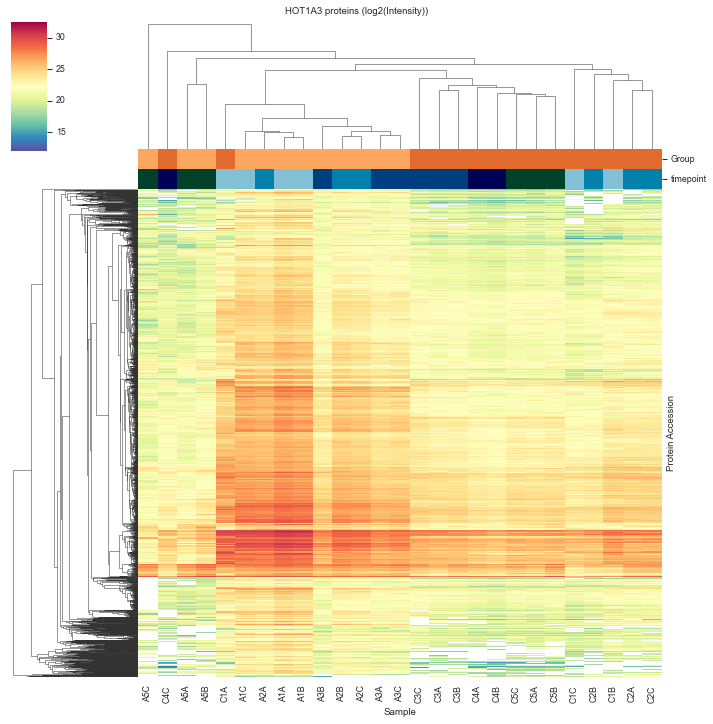

In [61]:
sns.set_context('paper')

adf = mdf.loc[mdf.Species.isin(['ALT'])& mdf.found_protein].pivot_table(values='log2Intensity', fill_value=0, index='Protein Accession', columns='Sample' )

col_anno = pd.DataFrame(adf.columns.to_list())
col_anno.index= col_anno[0]
col_anno['Group']=col_anno[0].str.get(0)
col_anno['timepoint']=pd.to_numeric(col_anno[0].str.get(1))
cols=['Group', 'timepoint']
col_anno['Group'] = col_anno['Group'].map(alut_map)
col_anno['timepoint'] = col_anno['timepoint'].map(dict(zip([1,2,3,4,5], timepal)))


sns.clustermap(adf, yticklabels=False, cmap='Spectral_r', mask=(adf==0),
               col_colors=col_anno[cols],
              )
plt.suptitle('HOT1A3 proteins (log2(Intensity))', y=1)

C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1, 'HOT1A3 proteins (log2(Intensity))')

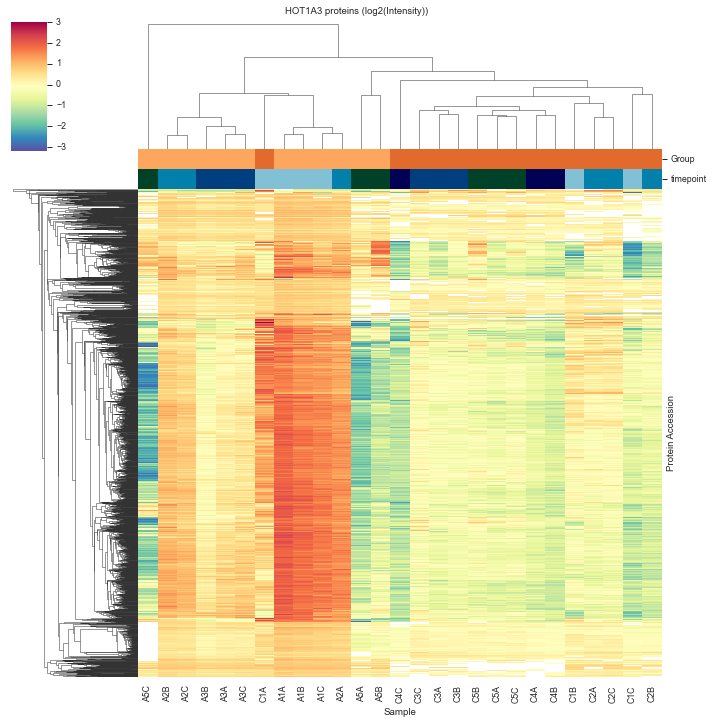

In [62]:
sns.set_context('paper')

adf = mdf.loc[mdf.Species.isin(['ALT'])& mdf.found_protein].pivot_table(values='log2Intensity', fill_value=0, index='Protein Accession', columns='Sample' )

col_anno = pd.DataFrame(adf.columns.to_list())
col_anno.index= col_anno[0]
col_anno['Group']=col_anno[0].str.get(0)
col_anno['timepoint']=pd.to_numeric(col_anno[0].str.get(1))
cols=['Group', 'timepoint']
col_anno['Group'] = col_anno['Group'].map(alut_map)
col_anno['timepoint'] = col_anno['timepoint'].map(dict(zip([1,2,3,4,5], timepal)))


sns.clustermap(adf, yticklabels=False, cmap='Spectral_r', mask=(adf==0),
               col_colors=col_anno[cols],
               z_score =0,
              )
plt.suptitle('HOT1A3 proteins (log2(Intensity))', y=1)

In [63]:
deseq_df.head()

,gene_id,gene,product,status,main,sub,path,ecpath,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,contrast,Length,organism,protein_id
0,TX50_RS00020,dnaN,DNA polymerase III subunit beta,no_significant,09120 Genetic Information Processing // 09180 ...,09124 Replication and repair // 09182 Protein ...,03030 DNA replication [PATH:ko03030] // 03430 ...,K02338 dnaN; DNA polymerase III subunit beta ...,1548.906501,0.228545,0.240451,0.950483,0.341867,0.461968,treatment_long.term_vs_ref,1155,MED4,WP_011131639.1
1,TX50_RS00025,TX50_RS00025,hypothetical protein,down,NaN,NaN,NaN,NaN,119.583771,-0.780791,0.232356,-3.360329,0.000778,0.003090,treatment_long.term_vs_ref,705,MED4,WP_011131640.1
2,TX50_RS00030,purL,phosphoribosylformylglycinamidine synthase sub...,up,09100 Metabolism,09104 Nucleotide metabolism,00230 Purine metabolism [PATH:ko00230],K23269 purL; phosphoribosylformylglycinamidin...,739.556937,0.776969,0.230531,3.370346,0.000751,0.003003,treatment_long.term_vs_ref,2337,MED4,WP_011131641.1
3,TX50_RS00035,purF,amidophosphoribosyltransferase,no_significant,09100 Metabolism // 09180 Brite Hierarchies,09104 Nucleotide metabolism // 09105 Amino aci...,00230 Purine metabolism [PATH:ko00230] // 0025...,"K00764 purF, PPAT; amidophosphoribosyltransfe...",362.706295,0.112800,0.131087,0.860498,0.389514,0.508454,treatment_long.term_vs_ref,1458,MED4,WP_011131642.1
4,TX50_RS00040,TX50_RS00040,DNA topoisomerase 4 subunit A,no_significant,09180 Brite Hierarchies,09182 Protein families: genetic information pr...,03032 DNA replication proteins [BR:ko03032] //...,K02469 gyrA; DNA gyrase subunit A [EC:5.6.2.2],725.124805,-0.254635,0.214104,-1.189304,0.234320,0.342085,treatment_long.term_vs_ref,2439,MED4,WP_011131643.1


In [64]:
def run_pca(X, metadf, sample_col='experiment_sample', n_components=2):
    scaledX = StandardScaler().fit_transform(X)
    principalComponents = pca.fit_transform(scaledX)
    print('Variance percent explained\n', pca.explained_variance_ratio_)
    pca_columns = [f'PCA{i}' for i in range(1,n_components+1)]
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = pca_columns)
    principalDf.set_index(X.index, inplace=True)
    dfpca = pd.merge(left=principalDf, left_index=True, right=metadf, right_on=sample_col)
    return dfpca


In [65]:
adf = mdf.loc[mdf.Species.isin(['ALT'])].pivot_table(values='log2Intensity', fill_value=1, index='Protein Accession', columns='Sample' )


In [66]:
adf.columns

Index(['A1A', 'A1B', 'A1C', 'A2A', 'A2B', 'A2C', 'A3A', 'A3B', 'A3C', 'A5A',
       'A5B', 'A5C', 'C1A', 'C1B', 'C1C', 'C2A', 'C2B', 'C2C', 'C3A', 'C3B',
       'C3C', 'C4A', 'C4B', 'C4C', 'C5A', 'C5B', 'C5C'],
      dtype='object', name='Sample')

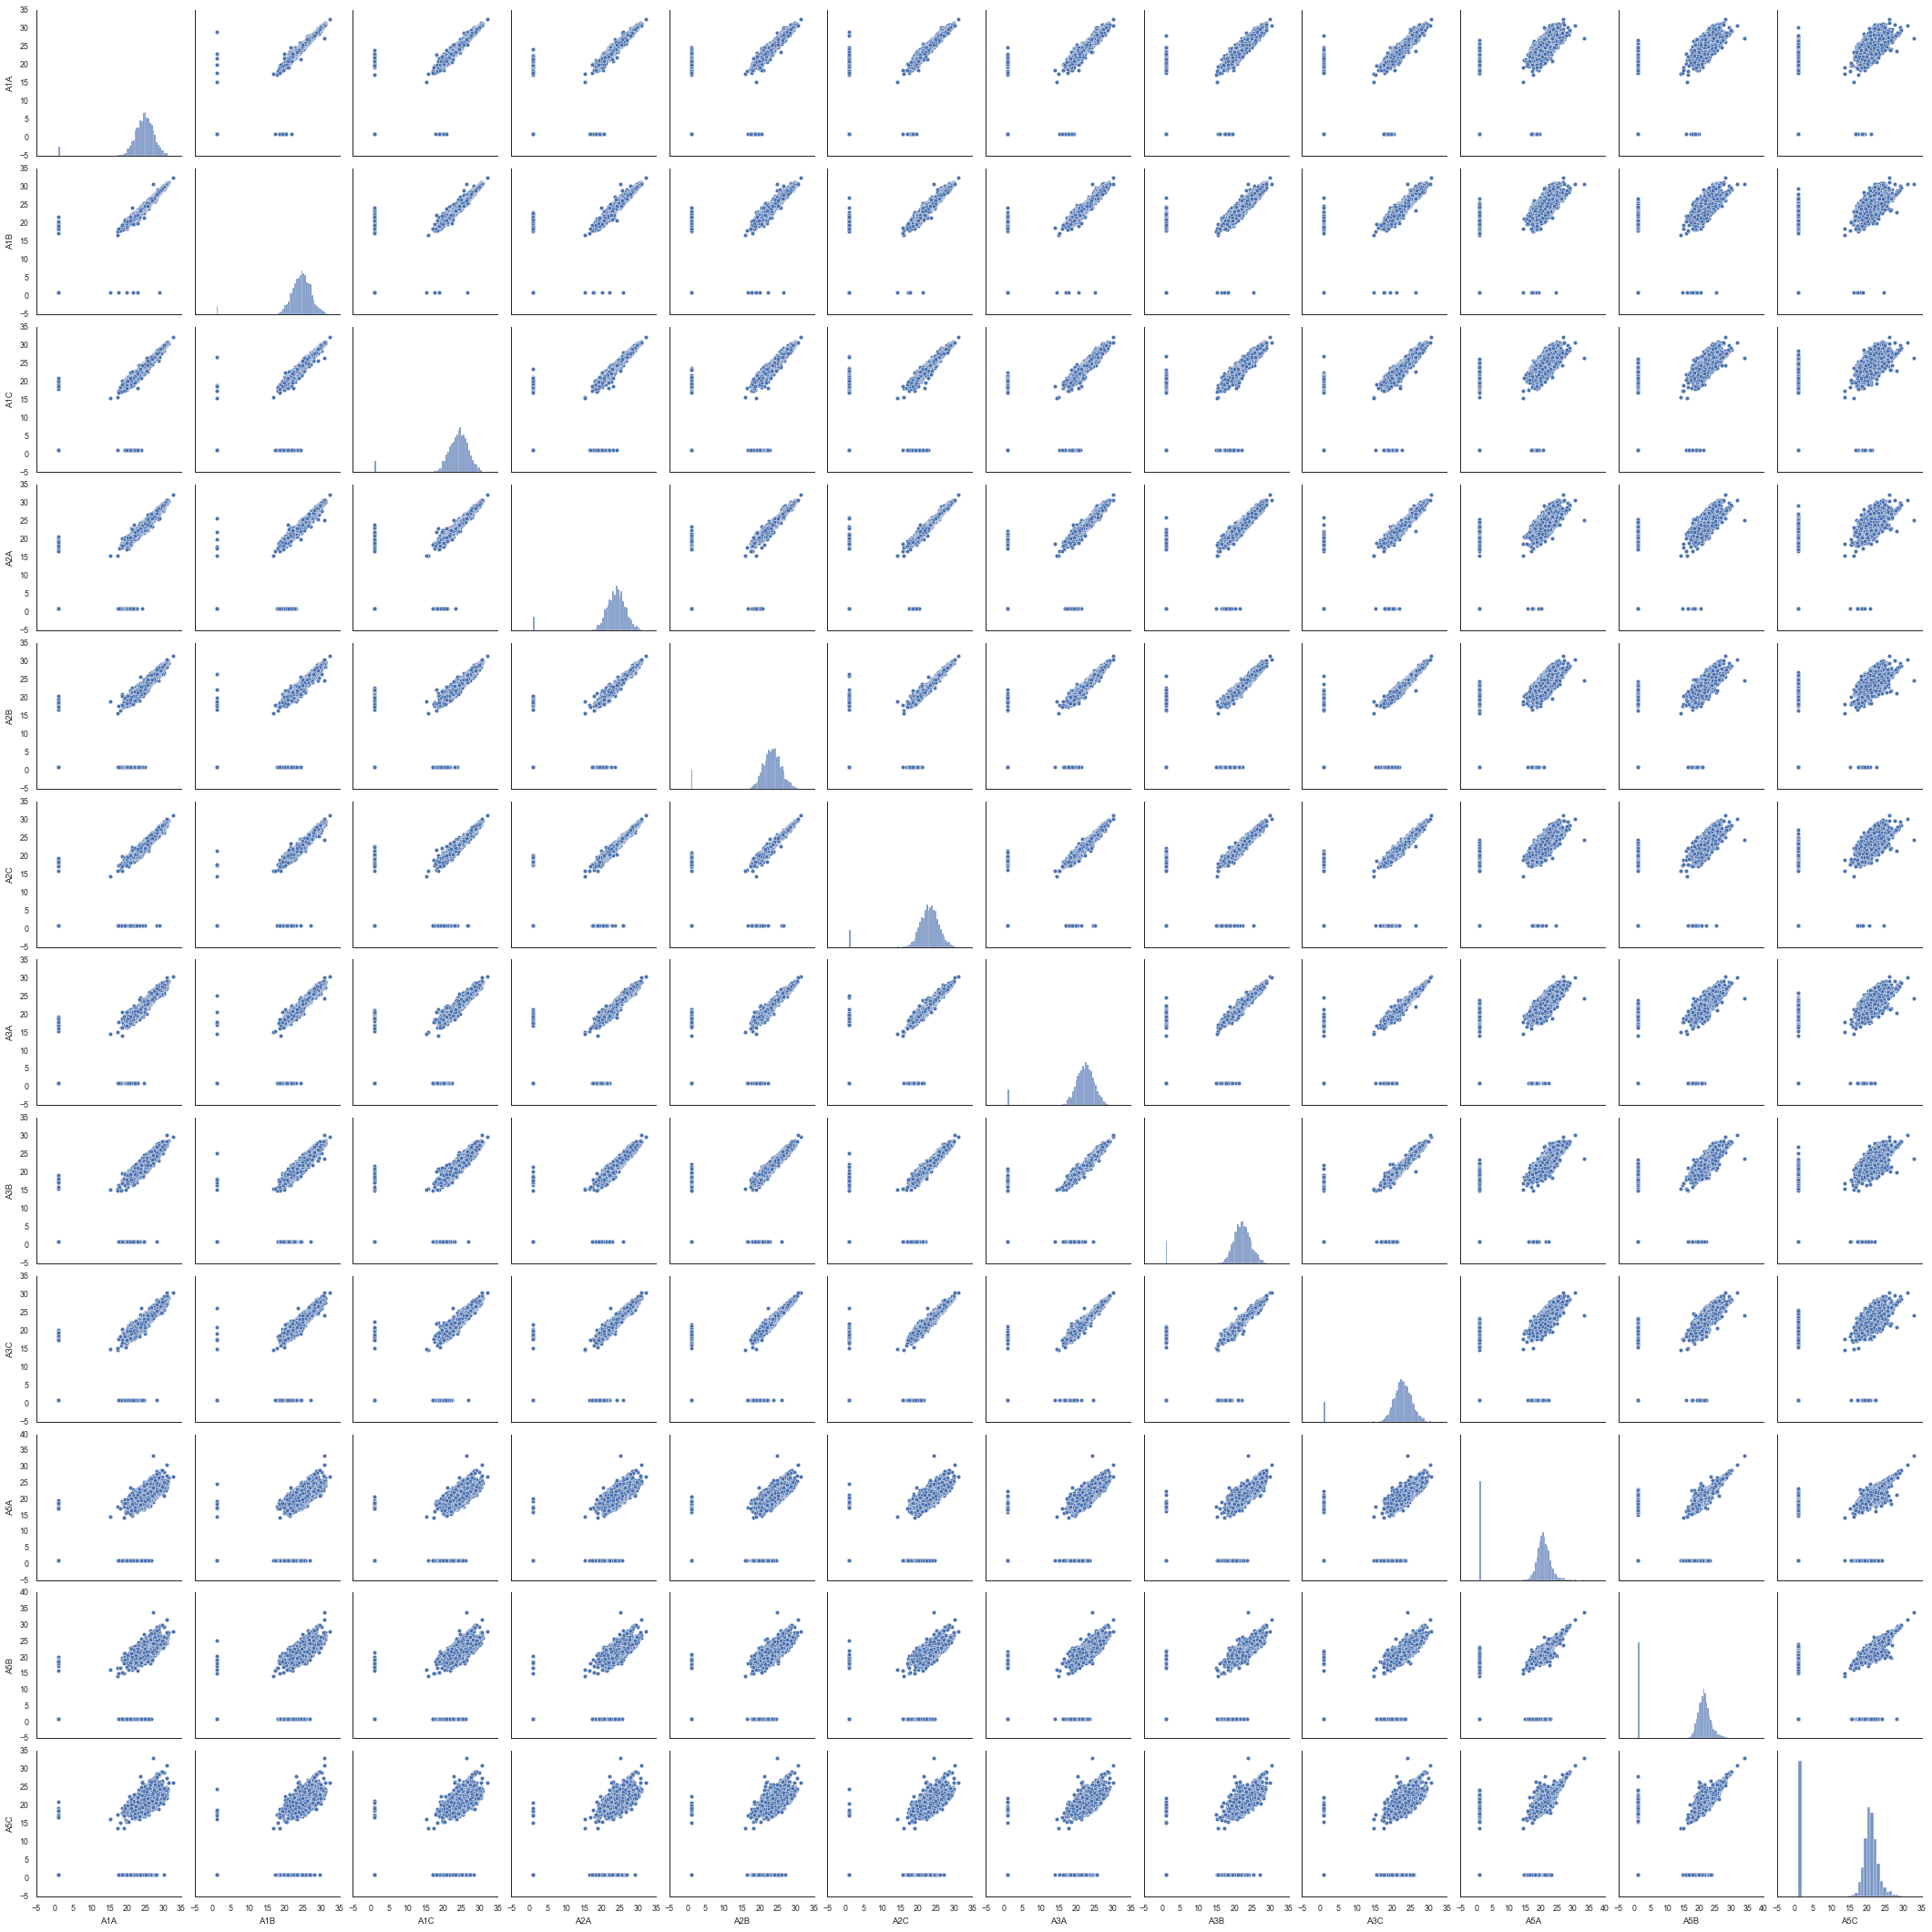

In [67]:
acols = ['A1A', 'A1B', 'A1C', 'A2A', 'A2B', 'A2C', 'A3A', 'A3B', 'A3C', 'A5A',
       'A5B', 'A5C']
ccols = ['C1A', 'C1B', 'C1C', 'C2A', 'C2B', 'C2C', 'C3A', 'C3B',
       'C3C', 'C4A', 'C4B', 'C4C', 'C5A', 'C5B', 'C5C']
sns.pairplot(adf, vars=acols)

In [68]:
adf = mdf.loc[mdf.Species.isin(['ALT'])& mdf.found_protein &mdf.viable_sample].pivot_table(values='log2Intensity', fill_value=1, index='Protein Accession', columns='Sample' )
n_components = 2
pca = PCA(n_components=2)
X = adf.T
scaledX = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(scaledX)
print('Variance percent explained\n', pca.explained_variance_ratio_)
pca_columns = [f'PCA{i} ({pca.explained_variance_ratio_[i-1]:.0%})' for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = pca_columns)
principalDf.set_index(X.index, inplace=True)
principalDf['Group']=principalDf.index.str.get(0)
principalDf['timepoint']=pd.to_numeric(principalDf.index.str.get(1))


Variance percent explained
 [0.71889022 0.08188342]


Text(0.5, 1.0, 'PCA of ALT (HOT1A3) proteins')

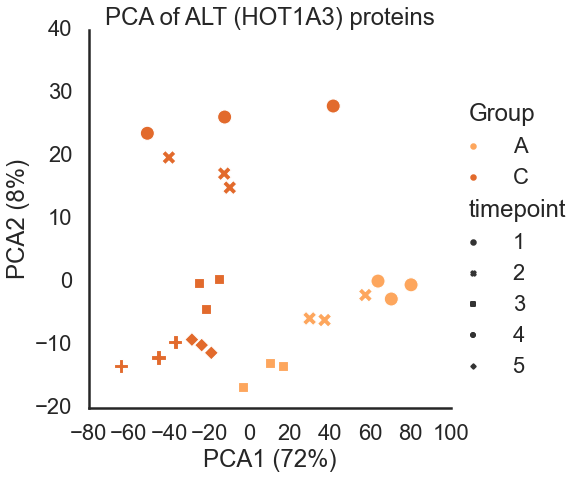

In [69]:
sns.set_context('poster')
xcol = [i for i in principalDf.columns if i.startswith('PCA1')][0]
ycol = [i for i in principalDf.columns if i.startswith('PCA2')][0]
sns.relplot(
    data=principalDf, x=xcol, y=ycol, hue='Group', style='timepoint', s=200,
    hue_order=['A', 'C'], palette=[HCOLOR_light, HCOLOR],
    height=7,
           )
plt.title('PCA of ALT (HOT1A3) proteins')

In [70]:
pdf = mdf.loc[mdf.Species.isin(['PRO'])& mdf.found_protein& mdf.viable_sample].pivot_table(values='log2Intensity', fill_value=1, 
                                                     index='Protein Accession', columns='Sample' )
n_components = 2
pca = PCA(n_components=2)
X = pdf.T
scaledX = StandardScaler().fit_transform(X)

principalComponents = pca.fit_transform(scaledX)
print('Variance percent explained\n', pca.explained_variance_ratio_)
pca_columns = [f'PCA{i} ({pca.explained_variance_ratio_[i-1]:.0%})' for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = pca_columns)
principalDf.set_index(X.index, inplace=True)
principalDf['Group']=principalDf.index.str.get(0)
principalDf['timepoint']=pd.to_numeric(principalDf.index.str.get(1))


Variance percent explained
 [0.77871403 0.05358458]


Text(0.5, 1.0, 'PCA of PRO (MED4) proteins')

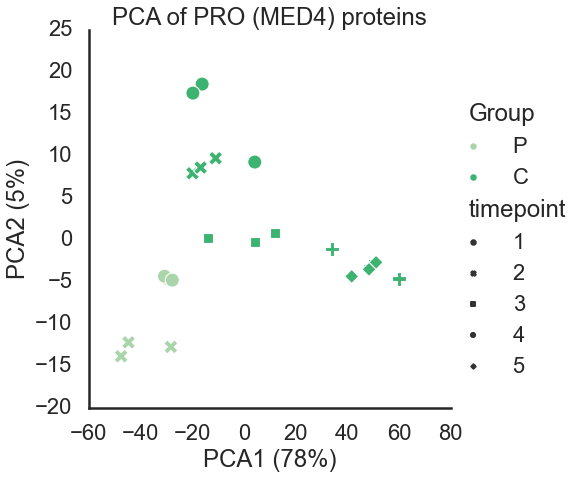

In [71]:
sns.set_context('poster')
xcol = [i for i in principalDf.columns if i.startswith('PCA1')][0]
ycol = [i for i in principalDf.columns if i.startswith('PCA2')][0]
sns.relplot(
    data=principalDf, x=xcol, y=ycol, hue='Group', style='timepoint', s=200,
    hue_order=['P', 'C'], palette=[PCOLOR_light, PRO_COLOR],
    height=7,
           )
plt.title('PCA of PRO (MED4) proteins')

C:\Users\Osnat\anaconda3\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


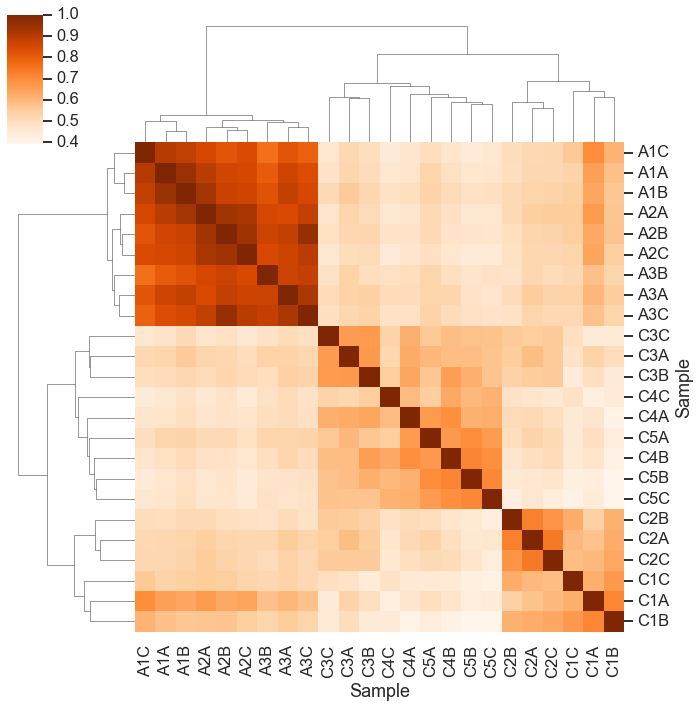

In [72]:
# corr = adf.corr()
# corr.style.background_gradient(cmap='coolwarm')

sns.set_context('talk')
corr = adf.corr()
sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            square=True,
            vmax=1,
            cmap='Oranges',
           )


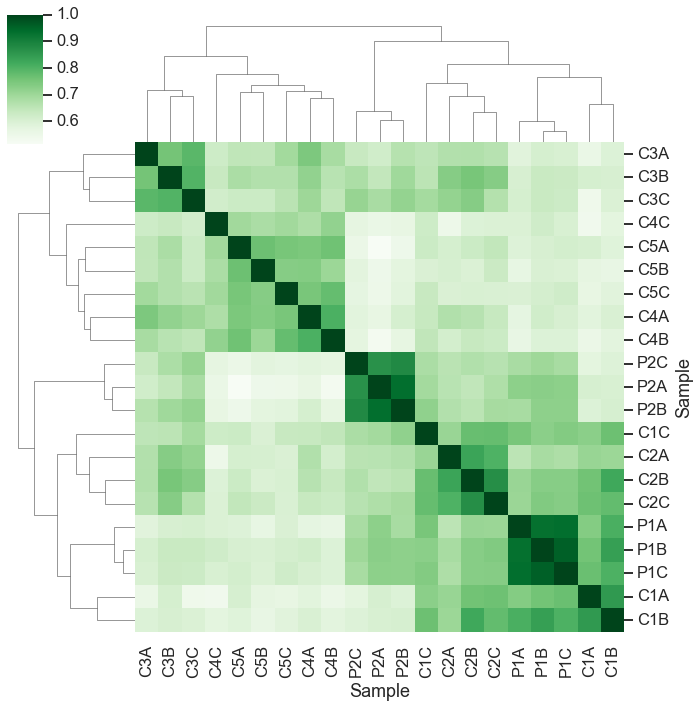

In [73]:
# corr = adf.corr()
# corr.style.background_gradient(cmap='coolwarm')

sns.set_context('talk')
corr = pdf.corr()
sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            square=True,
            vmax=1,
            cmap='Greens'
           )


In [74]:
mdf.loc[~mdf.found_protein].groupby(['Species', 'Protein Accession']).size().reset_index().Species.value_counts() #head(40)

ALT    773
PRO    131
Name: Species, dtype: int64